In [1]:
from functools import partial
from math import pi
import time

import flows
import haiku as hk
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from tqdm.auto import trange

from diffbank.metric import get_density as _get_density, get_g as _get_g
from diffbank.noise import Sn_aLIGO
from diffbank.utils import (
    get_m1_m2_sampler,
    gen_templates_rejection,
    get_template_frac_in_bounds,
    sample_uniform_metric_ellipse
)
from diffbank.waveforms.twoPN_simple import amp, Psi

from flow_utils import get_modules

## Templates as training data

Generate training data and fit flow

In [2]:
t_start = time.time()

In [10]:
key = random.PRNGKey(20)
# m_range = (1.0, 3.0)
m_range = (2.5, 3.0)
fs = jnp.linspace(20.0, 2000.0, 1000)
m1_m2_sampler = get_m1_m2_sampler(m_range, m_range)
get_density = jax.jit(lambda theta: _get_density(theta, amp, Psi, fs, Sn_aLIGO))
density_max = get_density(jnp.array([m_range[0], m_range[0]]))


@partial(jax.jit, static_argnums=(1,))
def sample_theta(key, n):
    return gen_templates_rejection(
        key, density_max, n, lambda _, theta: get_density(theta), m1_m2_sampler
    )


# Sample training set
key, subkey = random.split(key)
train_set = sample_theta(subkey, 10000)

# Sample validation set
key, subkey = random.split(key)
val_set = sample_theta(subkey, 2000)

In [11]:
# Definitions
modules = get_modules("realnvp", 5, True, 100)
bijection = flows.Serial(*modules)
prior = flows.Normal()
opt = optax.adam(3e-5)

# Initialize
init_fun = flows.Flow(bijection, prior)
key, subkey = random.split(key)
params, log_pdf, sample = init_fun(subkey, input_dim=2)
opt_state = opt.init(params)


@jax.jit
def loss(params, batch):
    """Negative log-likelihood"""
    return -log_pdf(params, batch).sum()


@jax.jit
def update(params, opt_state, batch):
    """Learning rule"""
    value, grads = jax.value_and_grad(loss)(params, batch)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, value


# Training loop
train_losses = []
val_losses = []
val_interval = 4
n_steps = 400
batch_size = 128

with trange(n_steps) as pbar:
    for i in pbar:
        # Validation step
        if i % val_interval == 0:
            val_loss = loss(params, val_set)
            val_losses.append(val_loss / len(val_set))
            pbar.set_description(f"val: {val_losses[-1]}")

        # Train
        key, subkey = random.split(key)
        batches = jnp.array_split(
            random.permutation(subkey, train_set), len(train_set) // batch_size
        )
        epoch_loss = 0.
        for batch in batches:
            params, opt_state, batch_loss = update(params, opt_state, batch)
            epoch_loss += batch_loss
        train_losses.append(epoch_loss / len(train_set))

  0%|          | 0/400 [00:00<?, ?it/s]

In [5]:
t_end = time.time()

In [6]:
print(f"Duration: {(t_end - t_start) / 60} min")

Duration: 1.264163601398468 min


Plotting

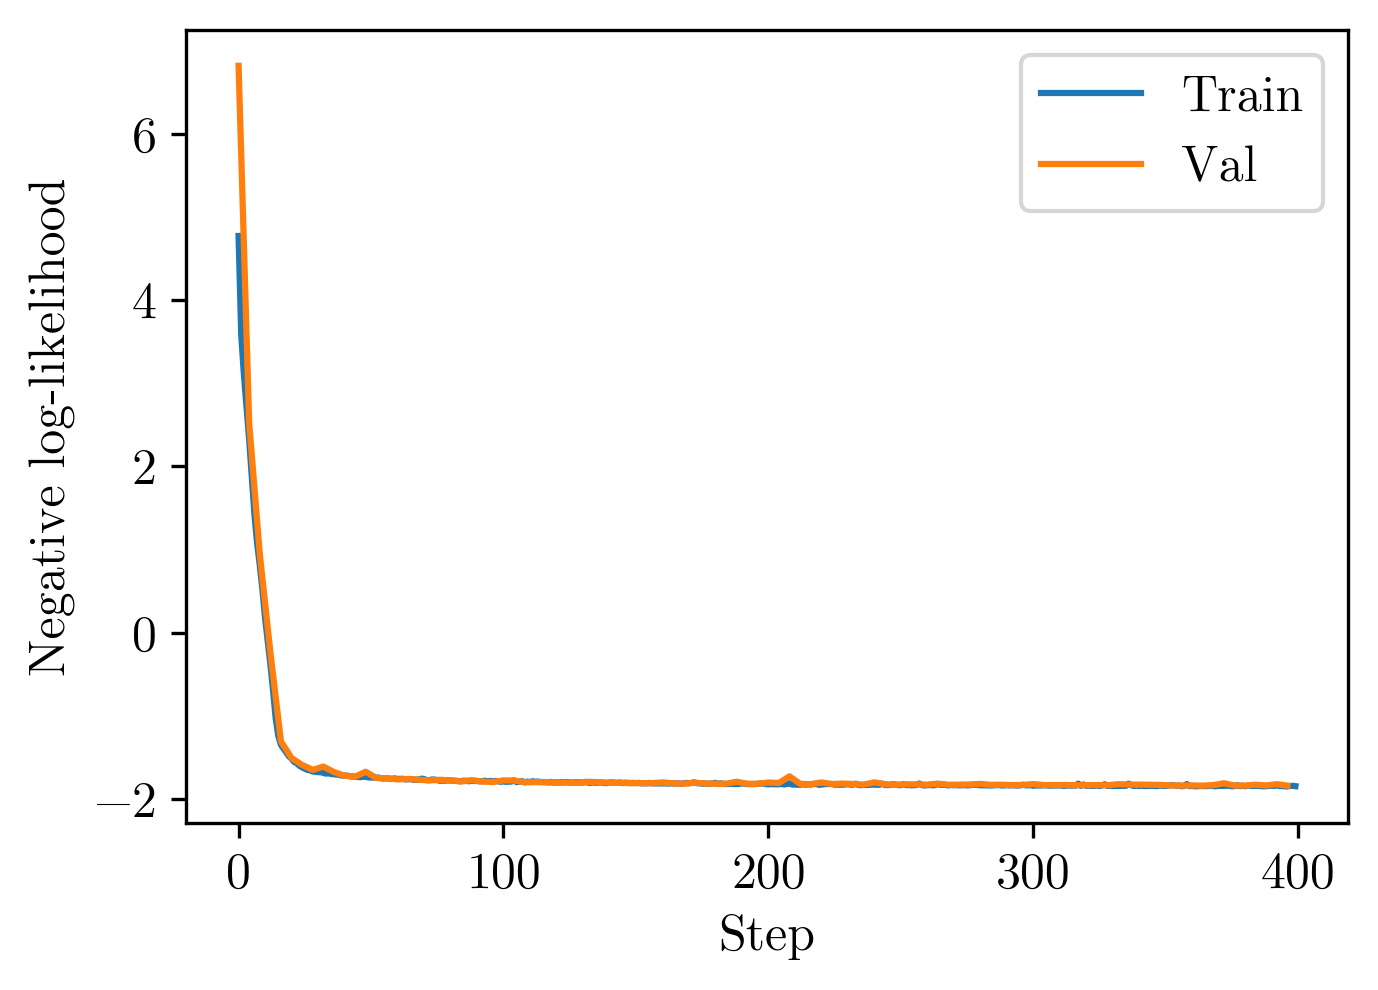

In [12]:
plt.plot(train_losses, label="Train")
plt.plot(jnp.arange(0, n_steps, val_interval), val_losses, label="Val")
plt.xlabel("Step")
plt.ylabel("Negative log-likelihood")
plt.legend()

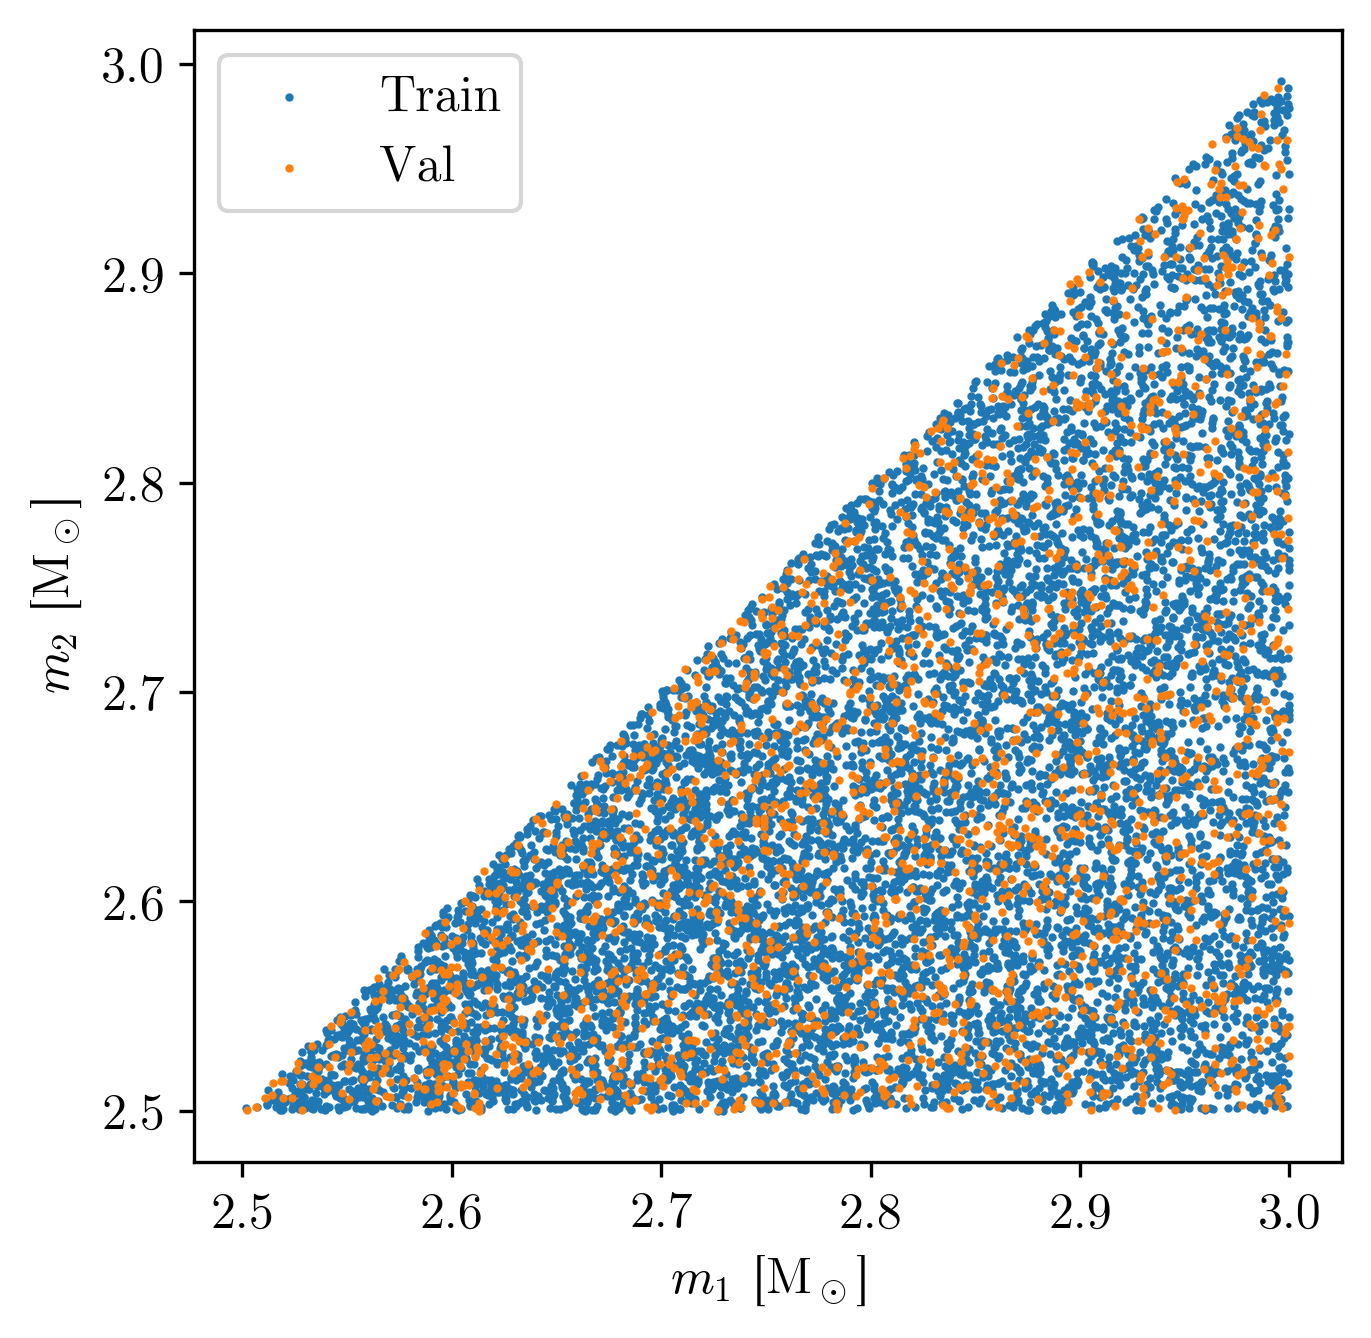

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter(*train_set.T, s=1, label="Train")
plt.scatter(*val_set.T, s=1, label="Val")
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")
plt.legend()
plt.gca().set_aspect("equal")

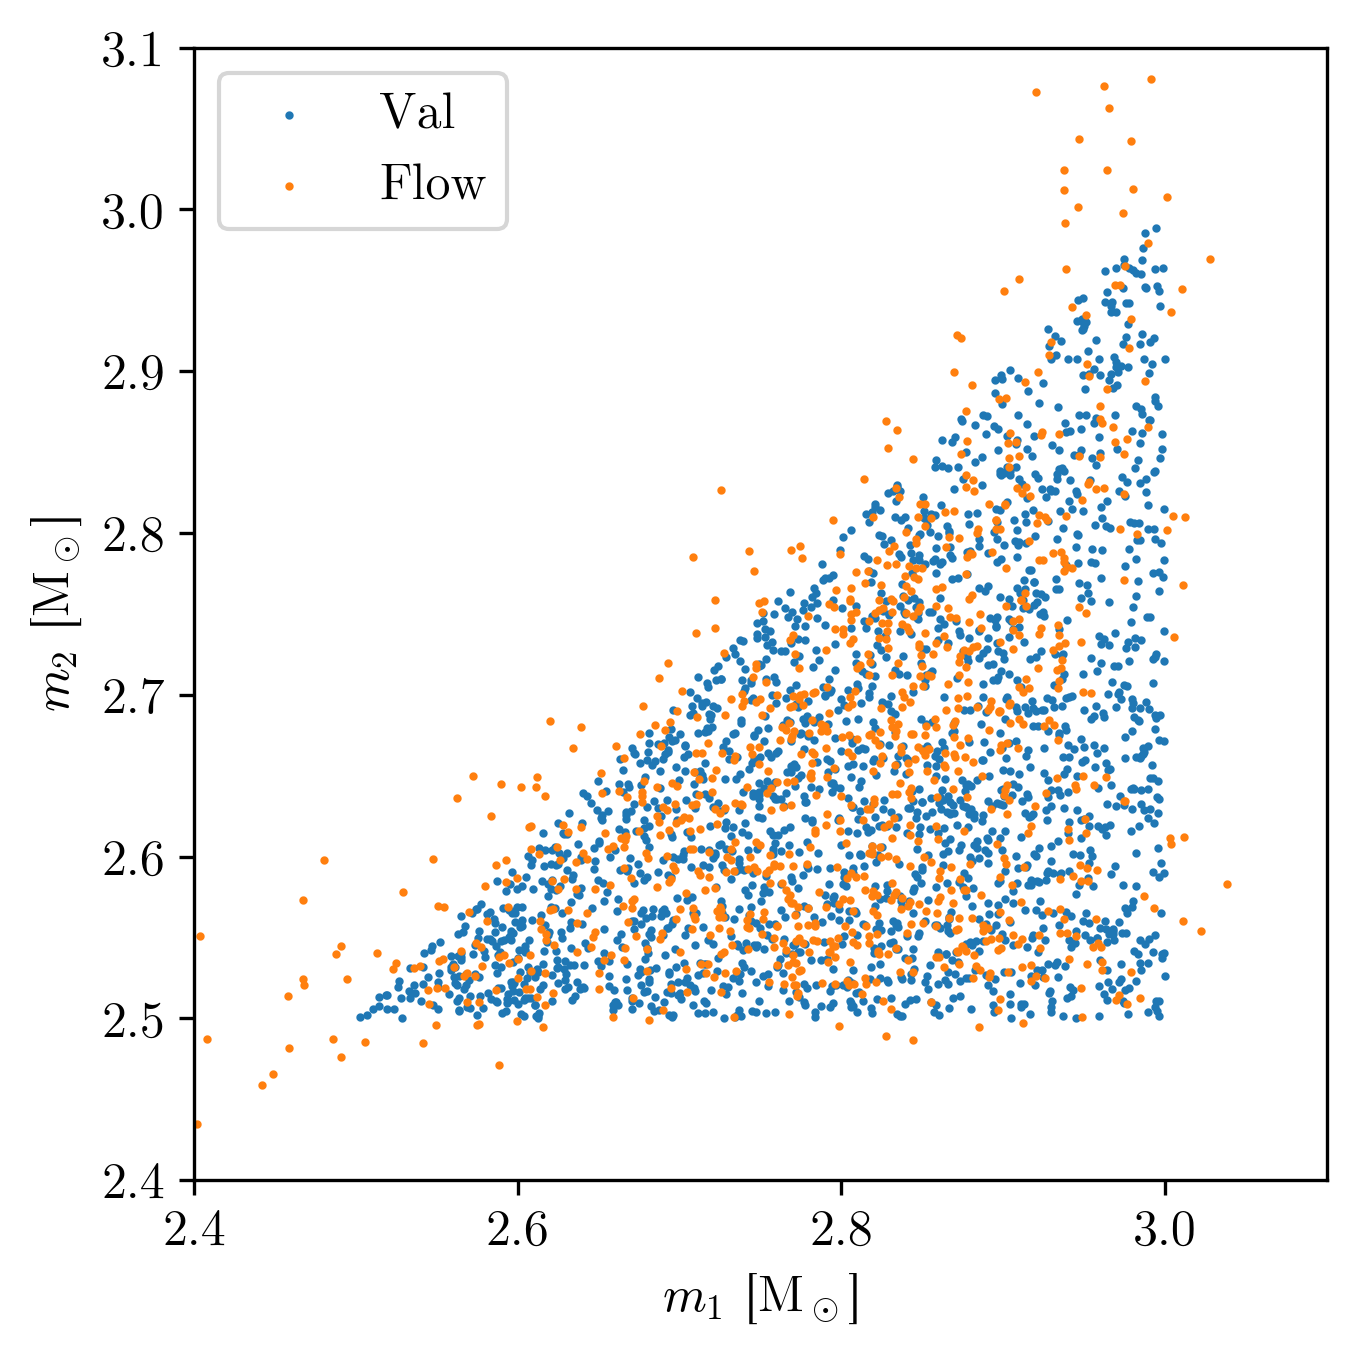

In [16]:
plt.figure(figsize=(5, 5))
# plt.scatter(*train_set.T, s=1, label="Train")
plt.scatter(*val_set.T, s=1, label="Val")

key, subkey = random.split(key)
plt.scatter(*sample(subkey, params, 1000).T, s=1, label="Flow")

plt.xlim(m_range[0] - 0.1, m_range[1] + 0.1)
plt.ylim(m_range[0] - 0.1, m_range[1] + 0.1)
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")
plt.legend(loc="upper left")
plt.gca().set_aspect("equal")

## Points weighted by density as training data

Generate training data and fit flow

In [17]:
t_start = time.time()

In [63]:
key = random.PRNGKey(20)
# m_range = (1.0, 3.0)
m_range = (2.5, 3.0)
fs = jnp.linspace(20.0, 2000.0, 1000)
m1_m2_sampler = get_m1_m2_sampler(m_range, m_range)
get_density = jax.jit(lambda theta: _get_density(theta, amp, Psi, fs, Sn_aLIGO))
density_max = get_density(jnp.array([m_range[0], m_range[0]]))


def sample_theta(key, n):
    return m1_m2_sampler(key, n)

In [64]:
# Definitions
modules = get_modules("realnvp", 5, True, 100)
bijection = flows.Serial(*modules)
prior = flows.Normal()
opt = optax.adam(2e-4)

# Initialize
init_fun = flows.Flow(bijection, prior)
key, subkey = random.split(key)
params, log_pdf, sample = init_fun(subkey, input_dim=2)
opt_state = opt.init(params)


@jax.jit
def loss(params, batch):
    """Negative log-likelihood"""
    densities = jax.vmap(get_density)(batch)
    return -(densities / density_max * log_pdf(params, batch)).sum()


@jax.jit
def update(params, opt_state, batch):
    """Learning rule"""
    value, grads = jax.value_and_grad(loss)(params, batch)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, value


# Training loop
train_losses = []
val_losses = []
val_interval = 5
n_steps = 1000
batch_size = 512

with trange(n_steps) as pbar:
    for i in pbar:
        # Validation step
        if i % val_interval == 0:
            key, subkey = random.split(key)
            val_batch = sample_theta(subkey, batch_size)
            val_loss = loss(params, val_batch)
            val_losses.append(val_loss)
            pbar.set_description(f"val: {val_losses[-1]}")

        # Train
        key, subkey = random.split(key)
        train_batch = sample_theta(subkey, batch_size)
        params, opt_state, train_loss = update(params, opt_state, train_batch)
        train_losses.append(train_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [65]:
t_end = time.time()

In [66]:
print(f"Duration: {(t_end - t_start) / 60} min")

Duration: 96.86366269985835 min


Plotting

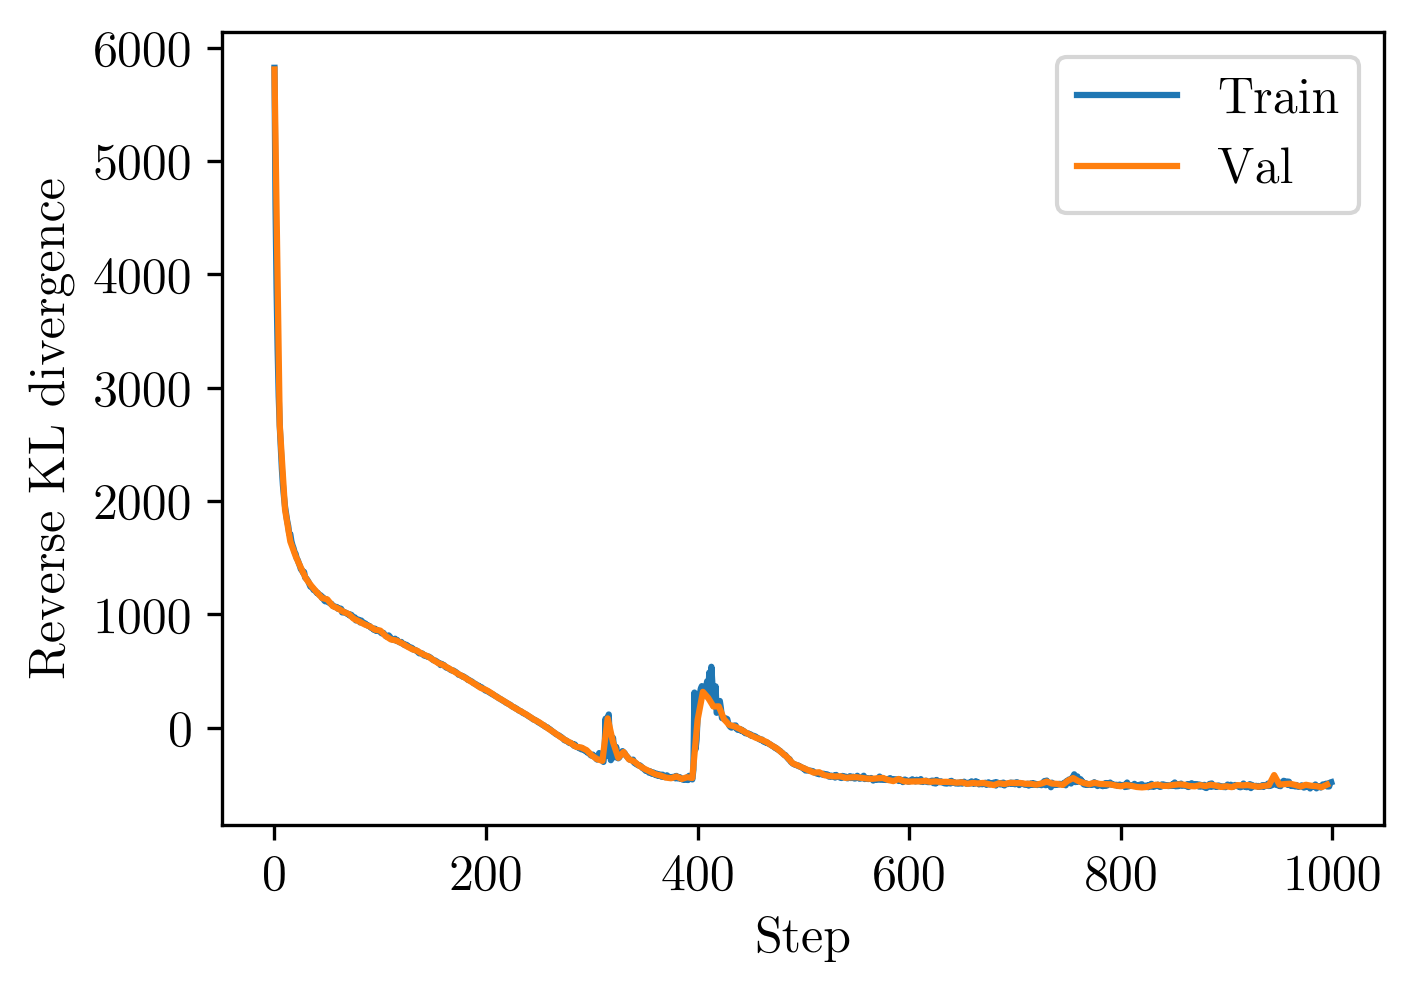

In [67]:
plt.plot(train_losses, label="Train")
plt.plot(jnp.arange(0, n_steps, val_interval), val_losses, label="Val")
plt.xlabel("Step")
plt.ylabel("Reverse KL divergence")
plt.legend()

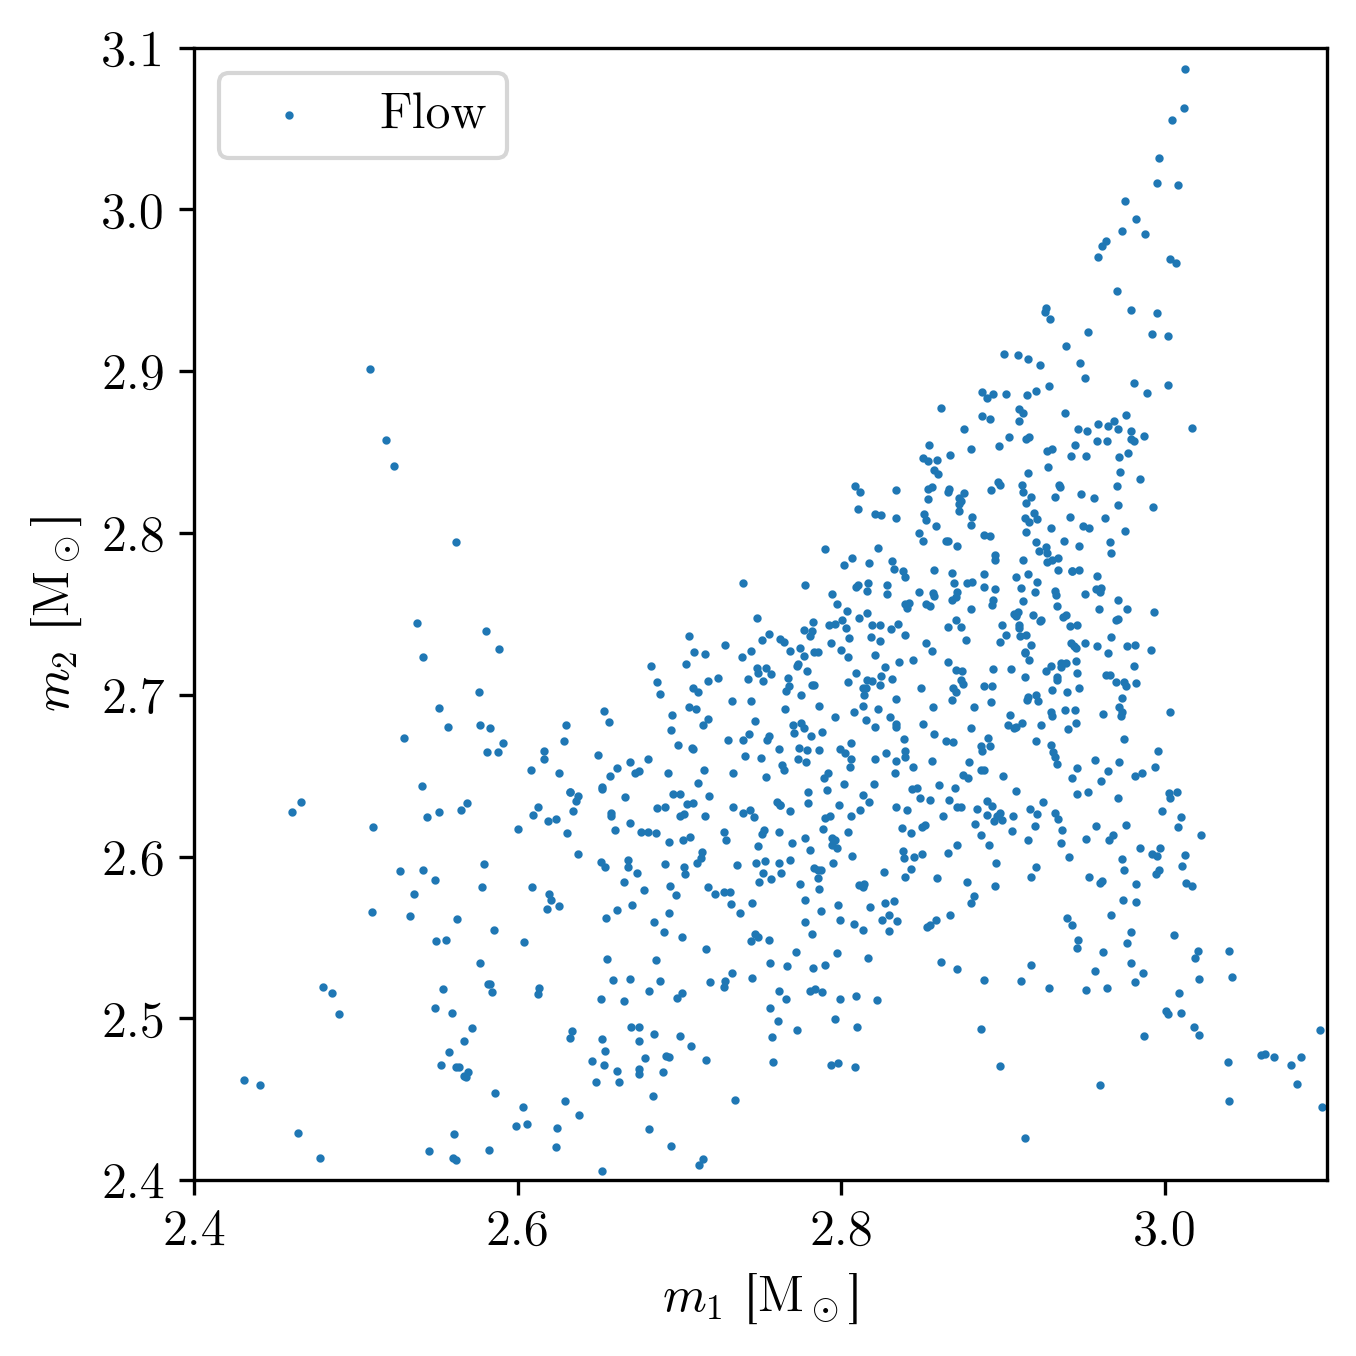

In [68]:
plt.figure(figsize=(5, 5))
# plt.scatter(*train_set.T, s=1, label="Train")
# plt.scatter(*val_set.T, s=1, label="Val")

key, subkey = random.split(key)
plt.scatter(*sample(subkey, params, 1000).T, s=1, label="Flow")

plt.xlim(m_range[0] - 0.1, m_range[1] + 0.1)
plt.ylim(m_range[0] - 0.1, m_range[1] + 0.1)
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")
plt.legend(loc="upper left")
plt.gca().set_aspect("equal")

## Fiddling

In [69]:
def is_in_bounds(theta):
    m1, m2 = theta.T
    return jnp.where(
        m1 < m_range[0],
        jnp.array(0.0),
        jnp.where(
            m1 > m_range[1],
            jnp.array(0.0),
            jnp.where(
                m2 < m_range[0],
                jnp.array(0.0),
                jnp.where(m2 > m1, jnp.array(0.0), jnp.array(1.0)),
            ),
        ),
    )

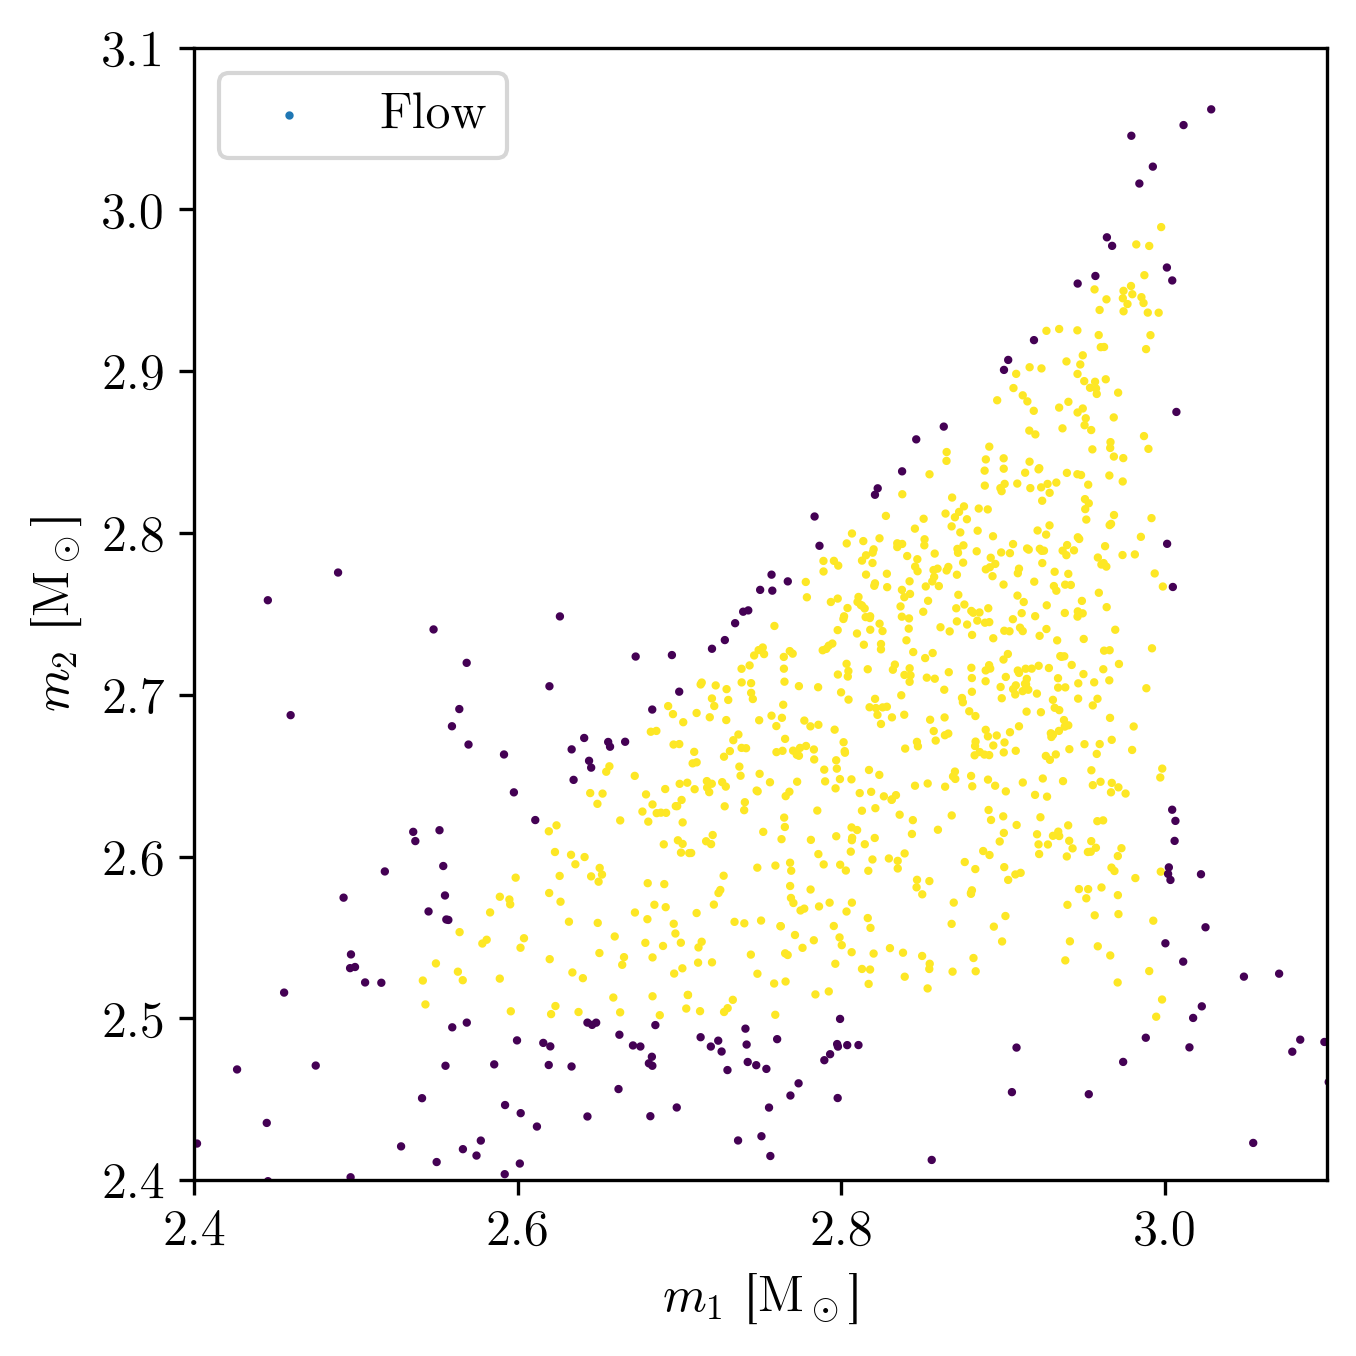

In [70]:
plt.figure(figsize=(5, 5))
# plt.scatter(*train_set.T, s=1, label="Train")
# plt.scatter(*val_set.T, s=1, label="Val")

key, subkey = random.split(key)
thetas = sample(subkey, params, 1000)
plt.scatter(*thetas.T, s=1, c=is_in_bounds(thetas), label="Flow")

plt.xlim(m_range[0] - 0.1, m_range[1] + 0.1)
plt.ylim(m_range[0] - 0.1, m_range[1] + 0.1)
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")
plt.legend(loc="upper left")
plt.gca().set_aspect("equal")

In [73]:
get_g = jax.jit(lambda theta: _get_g(theta, amp, Psi, fs, Sn_aLIGO))

In [74]:
theta = jnp.array([2.7, 2.65])
m_star = 0.05
key, subkey = random.split(key)
get_template_frac_in_bounds(subkey, theta, get_g, m_star, is_in_bounds, 1000000)

(DeviceArray(0.21897678, dtype=float64),
 DeviceArray(0.00041355, dtype=float64))

In [75]:
key, subkey = random.split(key)
ellipse_samples_0 = sample_uniform_metric_ellipse(subkey, get_g(theta), 1000)
ellipse_samples = jnp.sqrt(m_star) * ellipse_samples_0 + theta

In [81]:
ellipse_samples[is_in_bounds(ellipse_samples).astype(bool)][1]

DeviceArray([2.69330627, 2.55169313], dtype=float64)

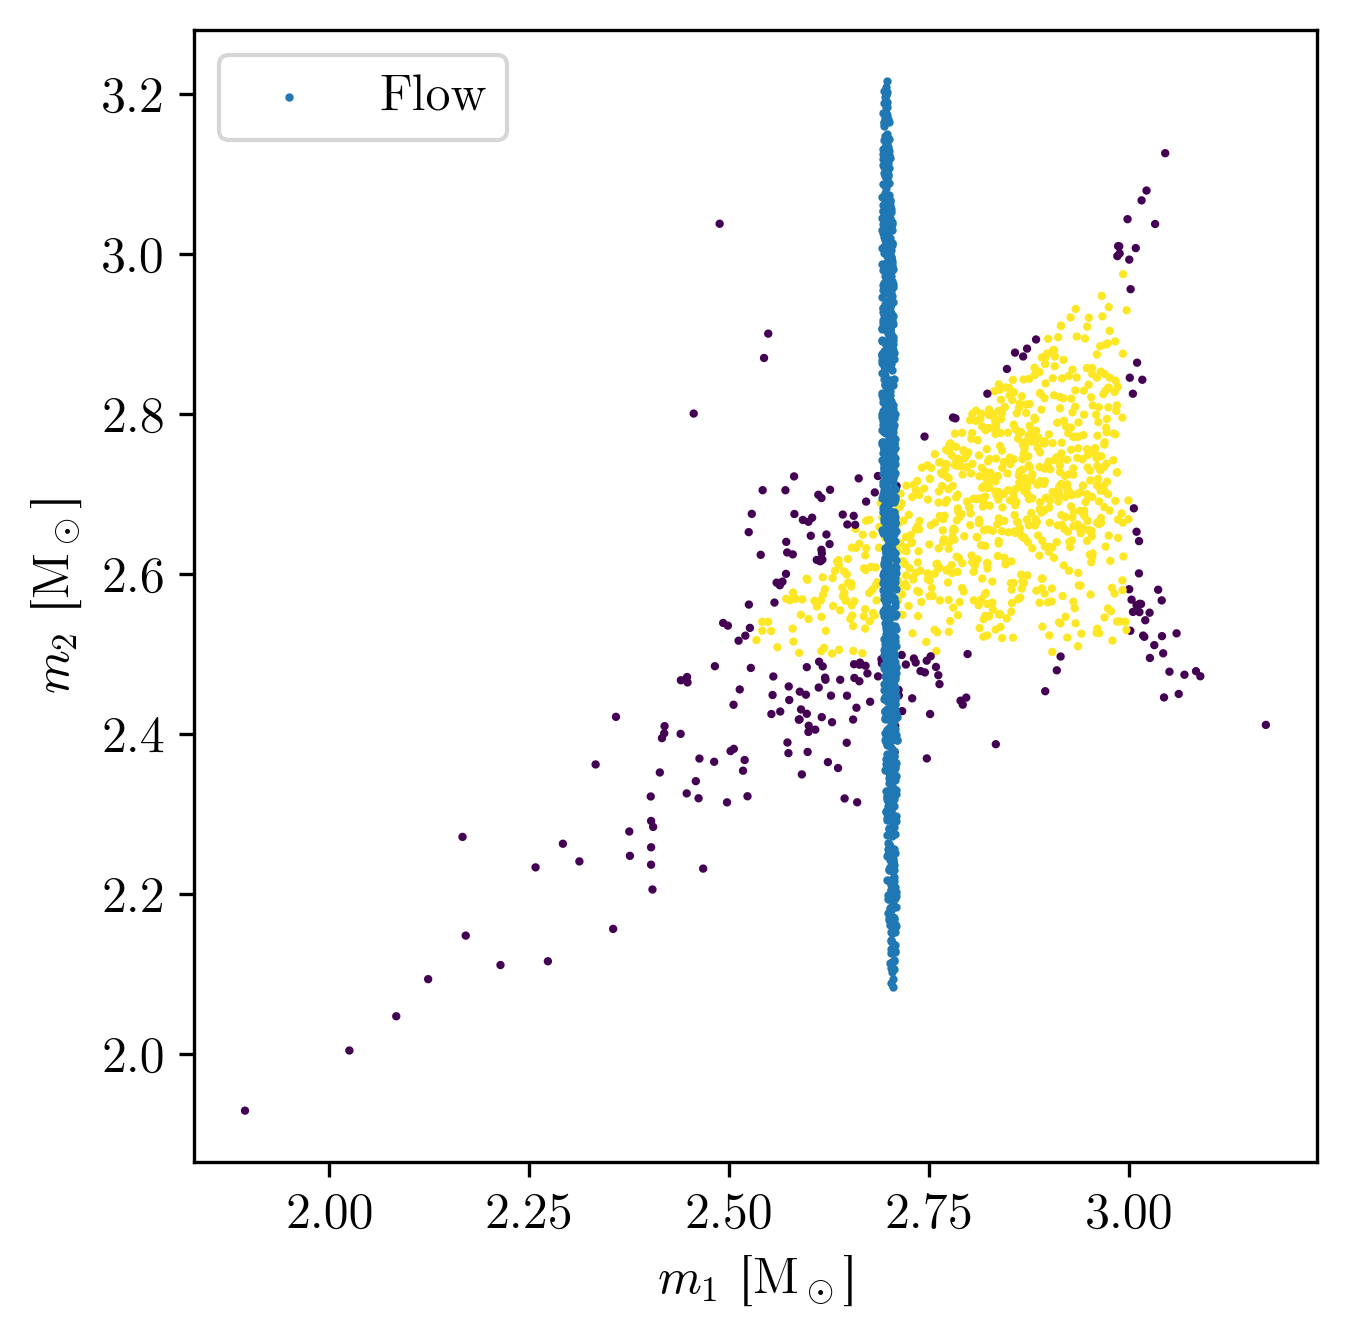

In [77]:
plt.figure(figsize=(5, 5))
key, subkey = random.split(key)
thetas = sample(subkey, params, 1000)
plt.scatter(*thetas.T, s=1, c=is_in_bounds(thetas), label="Flow")

plt.scatter(*ellipse_samples.T, s=1)

# plt.xlim(m_range[0] - 0.1, m_range[1] + 0.1)
# plt.ylim(m_range[0] - 0.1, m_range[1] + 0.1)
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")
plt.legend(loc="upper left")
plt.gca().set_aspect("equal")

## Toy problem

### Fiddling

In [64]:
key = random.PRNGKey(20)
x_range = (0.0, 5.0)
vol_space = (x_range[1] - x_range[0])**2
radius = 1.0
vol_template_oob = pi * radius**2


@jax.jit
def is_in_bounds(x):
    x1, x2 = x.T
    return jnp.where(
        x1 < x_range[0],
        jnp.array(0.0),
        jnp.where(
            x1 > x_range[1],
            jnp.array(0.0),
            jnp.where(
                x2 < x_range[0],
                jnp.array(0.0),
                jnp.where(
                    x2 > x_range[1],  # > x1,
                    jnp.array(0.0),
                    jnp.array(1.0)
                ),
            ),
        ),
    )


def sample_uniform(key, n):
    """
    Sample uniformly over space
    """
    return random.uniform(key, (n, 2), minval=x_range[0], maxval=x_range[1])


@jax.jit
def log_pdf(_, x):
    """
    Template sampling density
    """
    return jnp.full(x.shape, 1 / vol_space)


def sample_in_template_oob(key, n, x):
    """
    Sample in a template's covering ellipse, potentially including out-of-bounds
    points
    """
    key_t, key_u1, key_u2 = random.split(key, 3)
    t = 2 * pi * random.uniform(key_t, (n,))
    u = random.uniform(key_u1, (n,)) + random.uniform(key_u2, (n,))
    r = jnp.where(u > 1, 2 - u, u)
    return radius * jnp.stack([r * jnp.cos(t), r * jnp.sin(t)], axis=-1) + x


def sample_in_template(key, n, x):
    """
    Sample from a template's covering ellipse
    """
    template_samples = []
    while len(template_samples) < n:
        key, subkey = random.split(key)
        pt = sample_in_template_oob(subkey, 1, x)
        if is_in_bounds(pt):
            template_samples.append(pt)
    return jnp.stack(template_samples)

def get_f_ib(key, n, x):
    return is_in_bounds(sample_in_template_oob(key, n, x)).mean()


def sample_lam1_est(key, n, n_fib, sample, params):
    key_x, key_template, key_vol = random.split(key, 3)
    # Sample point in space
    x = sample(key_x, 1)
    # Sample positions of templates that could cover this point
    template_samples = sample_in_template(key_template, n, x)
    # Estimate f(z) over this volume
    vol_template = get_f_ib(key, n_fib, x)
    return x[0], vol_template * log_pdf(params, template_samples).mean()

In [23]:
xs = []
lam1_ests = []
for _ in range(200):
    key, subkey = random.split(key)
    x, lam1_est = sample_lam1_est(subkey, 10, 2000, sample_uniform)
    xs.append(x)
    lam1_ests.append(lam1_est)

xs = jnp.stack(xs)
lam1_est = jnp.array(lam1_est)

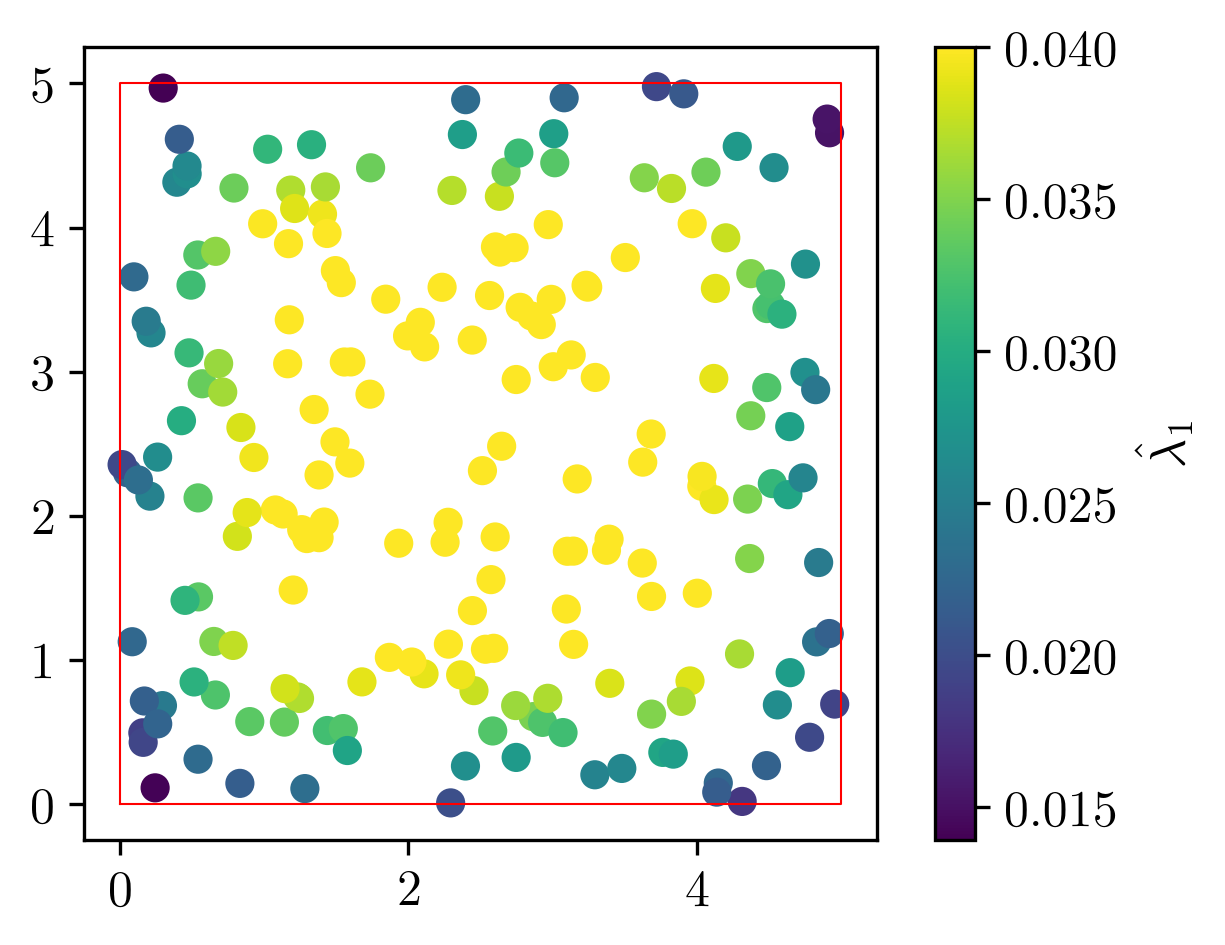

In [24]:
plt.scatter(*xs.T, c=lam1_ests)
plt.colorbar(label=r"$\hat{\lambda}_1$")

# for x in xs:
#     plt.gca().add_patch(plt.Circle(x, radius, alpha=0.05))

plt.plot(
    [x_range[0], x_range[1], x_range[1], x_range[0], x_range[0]],
    [x_range[0], x_range[0], x_range[1], x_range[1], x_range[0]],
    "r",
    linewidth=0.5
)

plt.gca().set_aspect("equal")

### Getting more serious

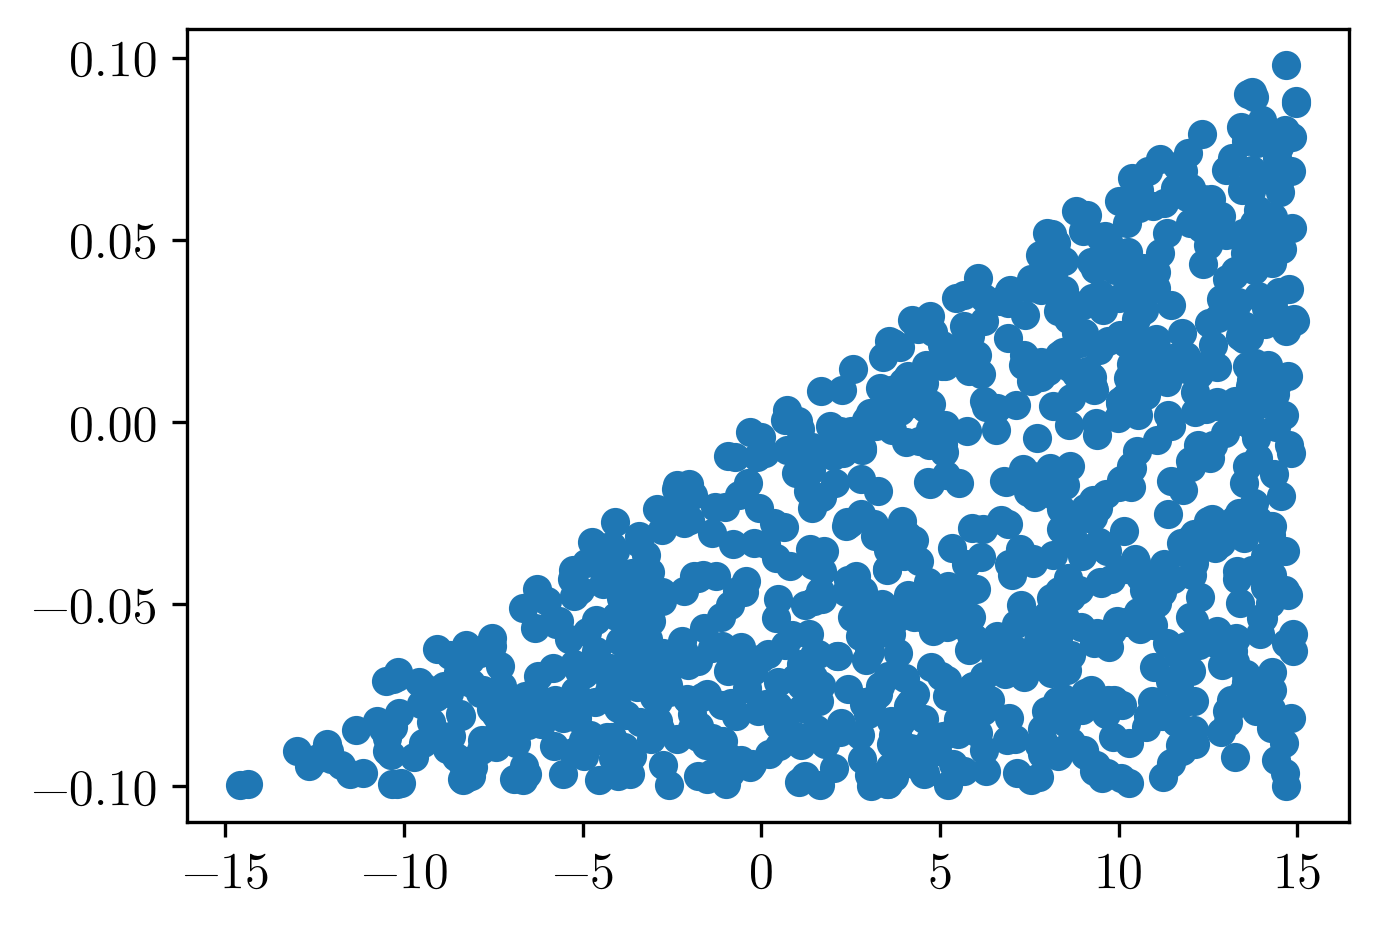

In [16]:
plt.scatter(*sample_uniform(key, 1000).T)

In [18]:
key = random.PRNGKey(20)
x1_range = (-15.0, 15.0)
x2_range = (-0.1, 0.1)
vol_space = (x1_range[1] - x1_range[0]) * (x2_range[1] - x2_range[0]) / 2
radius = 0.2
vol_template_oob = pi * radius ** 2


@jax.jit
def is_in_bounds(x):
    x1, x2 = x.T
    x1 = (x1 - x1_range[0]) / (x1_range[1] - x1_range[0])
    x2 = (x2 - x2_range[0]) / (x2_range[1] - x2_range[0])
    return jnp.where(
        x1 < 0,
        jnp.array(0.0),
        jnp.where(
            x1 > 1,
            jnp.array(0.0),
            jnp.where(
                x2 < 0,
                jnp.array(0.0),
                jnp.where(
                    x2 > x1,  # x2_range[1]
                    jnp.array(0.0),
                    jnp.array(1.0),
                ),
            ),
        ),
    )


def sample_uniform(key, n):
    """
    Sample uniformly over space
    """
    xs = random.uniform(key, (n, 2))
    return jnp.stack(
        [
            xs.max(1) * (x1_range[1] - x1_range[0]) + x1_range[0],
            xs.min(1) * (x2_range[1] - x2_range[0]) + x2_range[0],
        ]
    ).T


def plot_boundary(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(
        [x1_range[0], x1_range[1], x1_range[1], x1_range[0]],
        [x2_range[0], x2_range[0], x2_range[1], x2_range[0]],
        "r",
        linewidth=0.5,
    )


def sample_in_template_oob(key, n, x):
    """
    Sample in a template's covering ellipse, potentially including out-of-bounds
    points
    """
    key_t, key_u1, key_u2 = random.split(key, 3)
    t = 2 * pi * random.uniform(key_t, (n,))
    u = random.uniform(key_u1, (n,)) + random.uniform(key_u2, (n,))
    r = jnp.where(u > 1, 2 - u, u)
    return radius * jnp.stack([r * jnp.cos(t), r * jnp.sin(t)], axis=-1) + x


@jax.jit
def _sample_in_template_1(key, x):
    def body_fun(val):
        key, subkey = random.split(val[1])
        pt = sample_in_template_oob(subkey, 1, x)[0]
        return (pt, key)

    cond_fun = lambda val: jnp.logical_not(is_in_bounds(val[0]))
    # First pt doesn't matter
    init_val = body_fun((sample_in_template_oob(key, 1, x), key))
    return jax.lax.while_loop(cond_fun, body_fun, init_val)[0]


def sample_in_template(key, n, x):
    """
    Sample from a template's covering ellipse
    """
    return jax.lax.map(lambda key: _sample_in_template_1(key, x), random.split(key, n))


def get_f_ib(key, n, x):
    return is_in_bounds(sample_in_template_oob(key, n, x)).mean()


@partial(jax.jit, static_argnums=(2, 3))
def get_lam_mc_uniform(key, x, n_ts, n_fib):
    """
    Compute MC estimate of lam(x)
    """
    key_template, key_vol = random.split(key)
    # Sample positions of templates that could cover this point
    template_samples = sample_in_template(key_template, n_ts, x)
    # Get volume of in-bounds part of template's ellipse
    vol_template = get_f_ib(key, n_fib, x)
    # Estimate template PDF over this volume
    return vol_template / vol_space

Set up flow

In [19]:
# Definitions
modules = get_modules("realnvp", 5, True, 64)
bijection = flows.Serial(*modules)
prior = flows.Normal()
opt = optax.adam(4e-4)

# Initialize
init_fun = flows.Flow(bijection, prior)
key, subkey = random.split(key)
params, log_pdf, sample = init_fun(subkey, input_dim=2)


def get_effectualness(key, n_bank, n_eff, sample):
    # Generate the bank
    key_bank, key_eff = random.split(key)
    xs_bank = jax.lax.map(sample, random.split(key_bank, n_bank))
    xs_eff = sample_uniform(key_eff, n_eff)
    effs = jnp.sqrt(((xs_bank[:, None, :] - xs_eff[None, :, :])**2).sum(-1)).min(0)
    return xs_bank, xs_eff, effs

#### Pre-train flow to sample uniformly over space

In [20]:
opt_state = opt.init(params)


@jax.jit
def loss(params, batch):
    """Forward KL to uniform over space"""
    return -log_pdf(params, batch).mean()


@jax.jit
def update(params, opt_state, batch):
    """Learning rule"""
    value, grads = jax.value_and_grad(loss)(params, batch)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, value


# Training loop
train_losses = []
val_losses = []
val_interval = 20
n_steps = 3000
batch_size = 512

with trange(n_steps) as pbar:
    for i in pbar:
        # Validation step
        if i % val_interval == 0:
            key, subkey = random.split(key)
            val_batch = sample_uniform(subkey, batch_size)
            val_loss = loss(params, val_batch)
            val_losses.append(val_loss)
            pbar.set_description(f"val: {val_losses[-1]:.3f}")

        # Train
        key, subkey = random.split(key)
        train_batch = sample_uniform(subkey, batch_size)
        params, opt_state, train_loss = update(params, opt_state, train_batch)
        train_losses.append(train_loss)

  0%|          | 0/3000 [00:00<?, ?it/s]

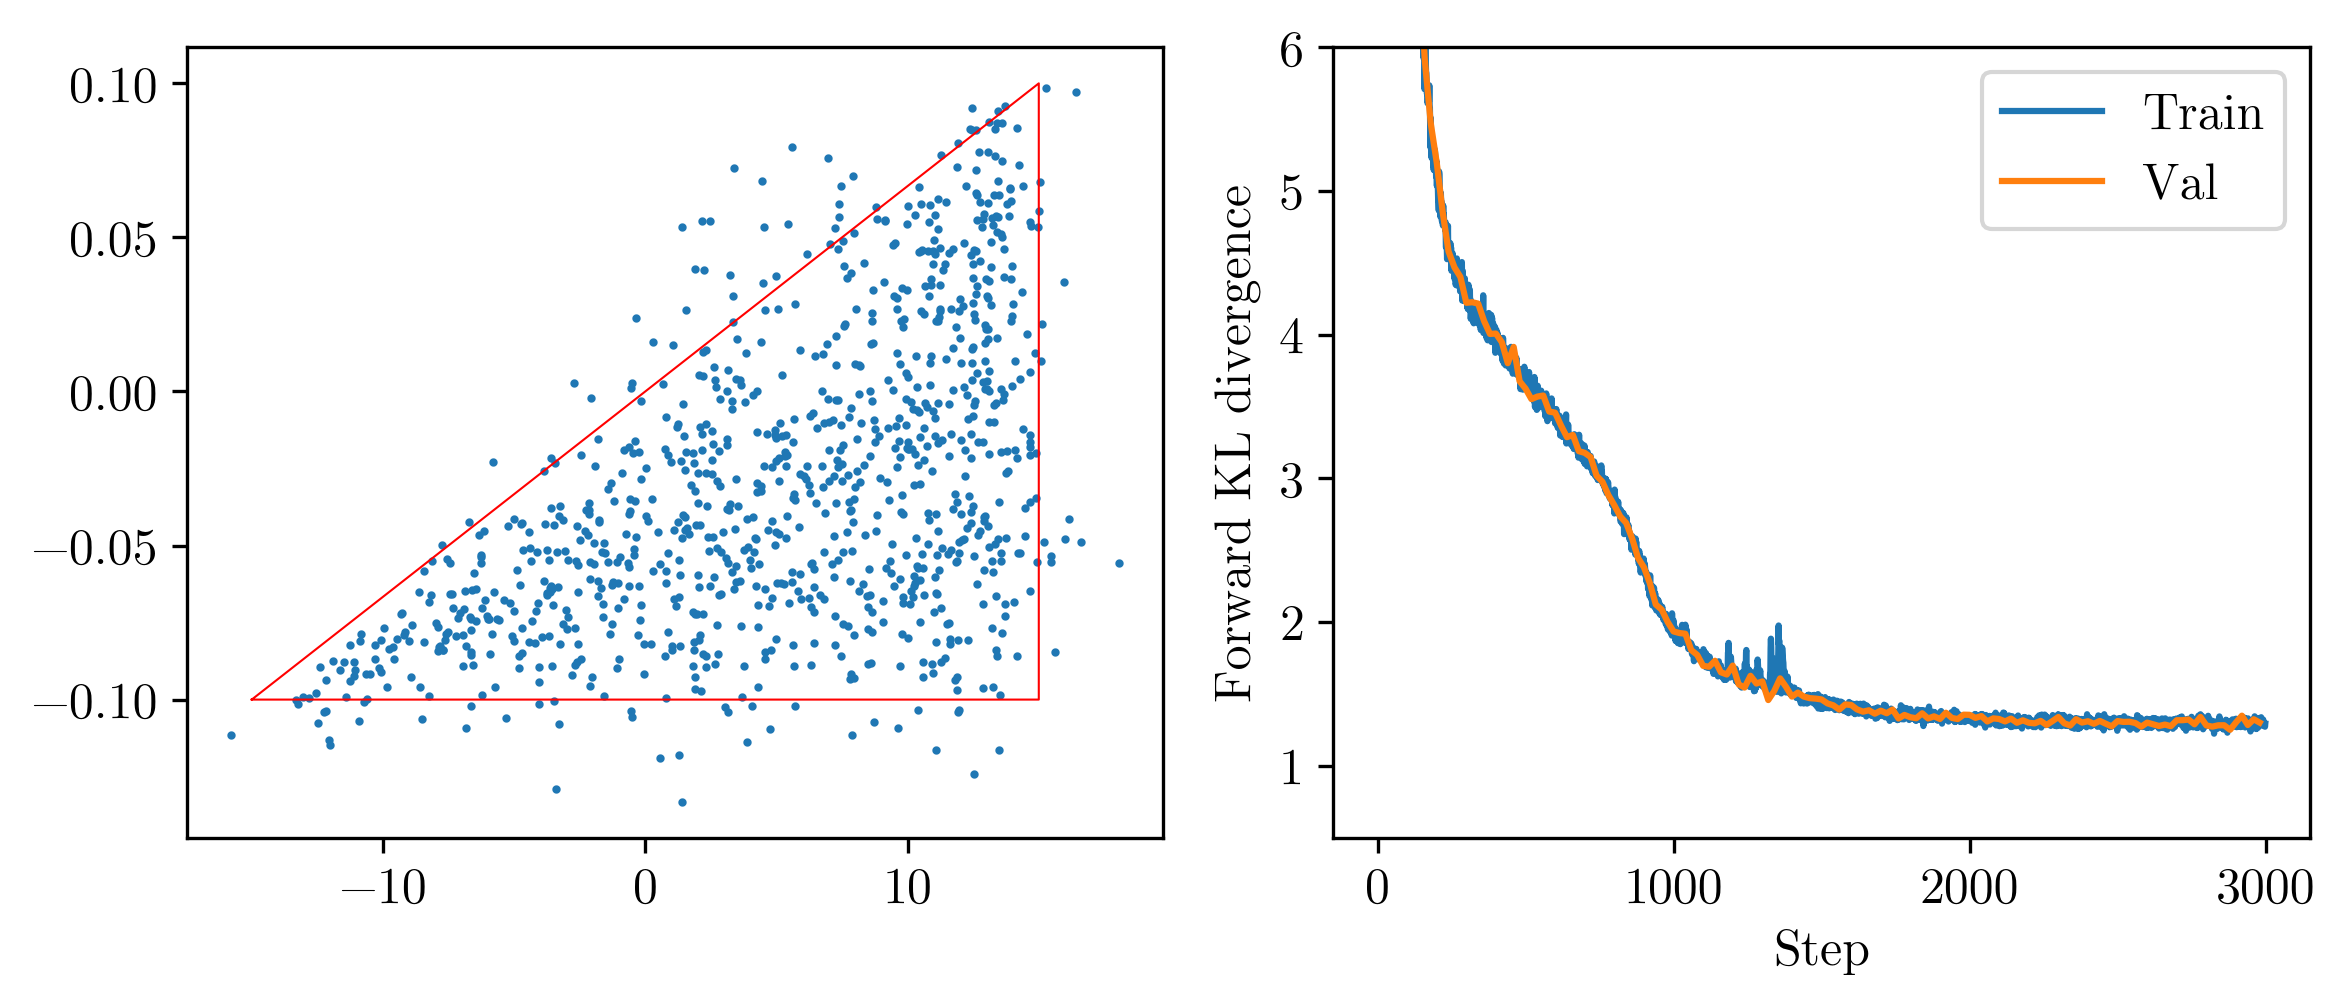

In [21]:
plt.figure(figsize=(8, 3.5))

plt.subplot(1, 2, 1)
plt.scatter(*sample(key, params, 1000).T, s=1)
plot_boundary()
# plt.gca().set_aspect("equal")

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train")
plt.plot(jnp.arange(0, n_steps, val_interval), val_losses, label="Val")
plt.xlabel("Step")
plt.ylabel("Forward KL divergence")
plt.ylim(0.5, 6)
plt.legend()

plt.tight_layout()

Text(0.5, 1.0, 'Covering rate (uniform)')

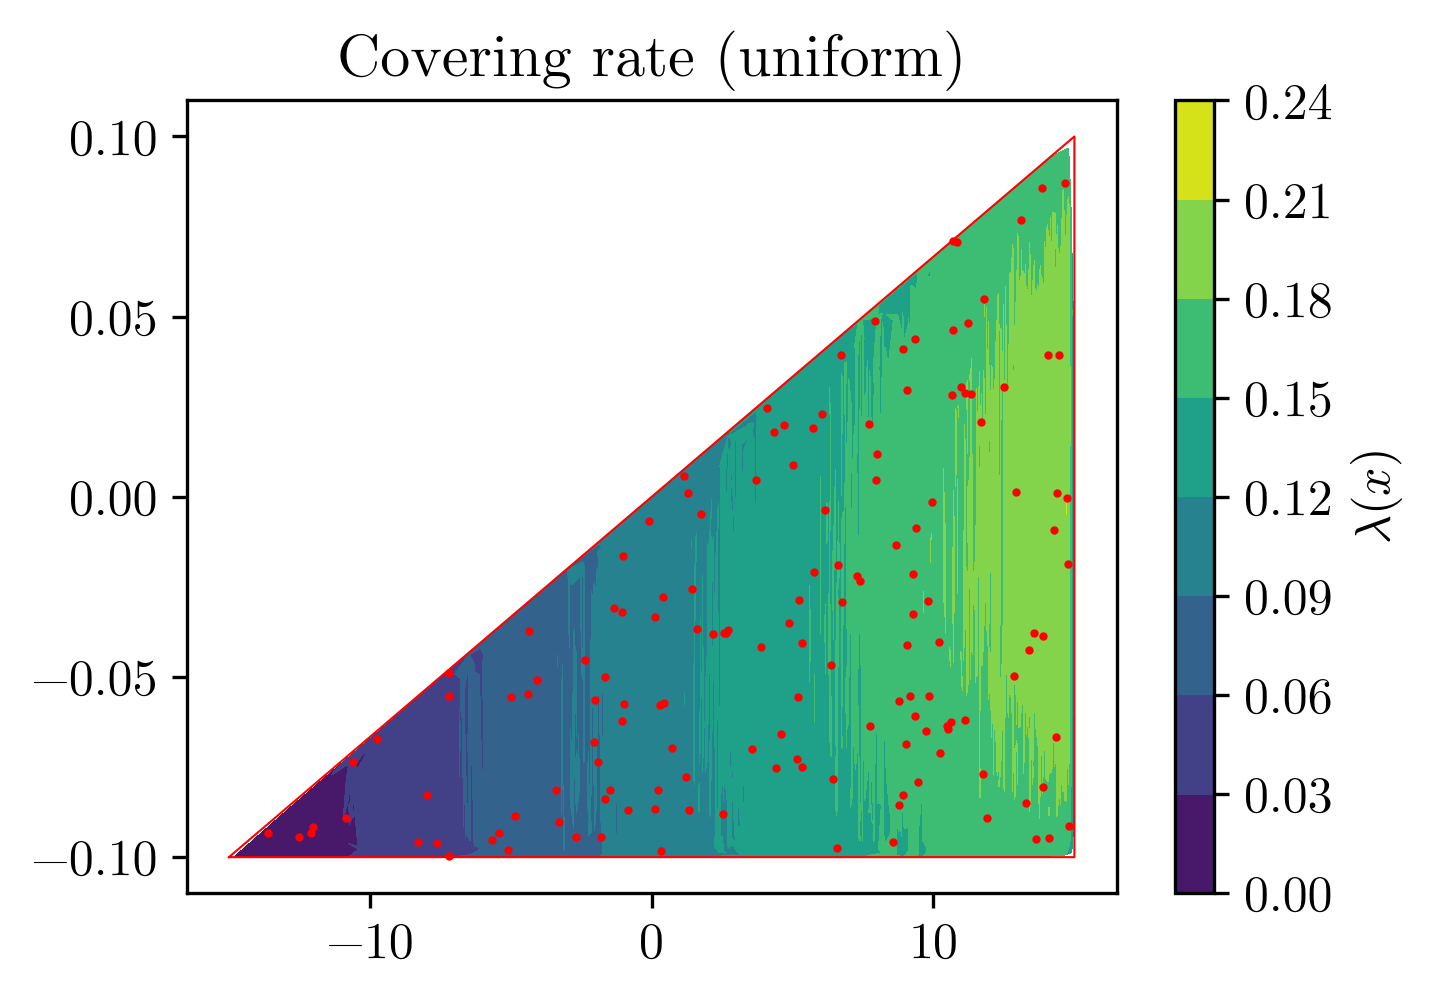

In [23]:
# Compute lam at some points, sampling templates uniformly
key, key_x, key_lam = random.split(key, 3)
xs = sample_uniform(key_x, 3000)
lam_ests = jax.lax.map(
    lambda val: get_lam_mc_uniform(val["key"], val["x"], 10, 1000),
    dict(key=random.split(key_lam, len(xs)), x=xs),
)

# Plot
plt.tricontourf(*xs.T, lam_ests)
plt.colorbar(label=r"$\lambda(x)$")
key, subkey = random.split(key)
xs = sample_uniform(subkey, 150)
plt.scatter(*xs.T, c="r", s=1)
plot_boundary()
# plt.gca().set_aspect("equal")
plt.title("Covering rate (uniform)")

#### Train flow to give uniform covering probability

In [24]:
@jax.jit
def sample_flow(key, params):
    """
    Sample a single point from the flow
    """
    def body_fun(val):
        key, subkey = random.split(val[1])
        x = sample(subkey, params)[0]
        return (x, key)

    cond_fun = lambda val: jnp.logical_not(is_in_bounds(val[0]))
    init_val = body_fun((sample(key, params), key))  # first x doesn't matter
    return jax.lax.while_loop(cond_fun, body_fun, init_val)[0]


@partial(jax.jit, static_argnums=(2, 3))
def get_lam_mc(key, x, n_ts, n_fib, params):
    """
    Compute MC estimate of lam(x)
    """
    key_template, key_vol = random.split(key)
    # Sample positions of templates that could cover this point
    template_samples = sample_in_template(key_template, n_ts, x)
    # Get volume of in-bounds part of template's ellipse
    vol_template = get_f_ib(key, n_fib, x)
    # Estimate template PDF over this volume
    return vol_template * jnp.exp(log_pdf(params, template_samples)).mean()

Text(0.5, 1.0, 'Initial covering rate (flow)')

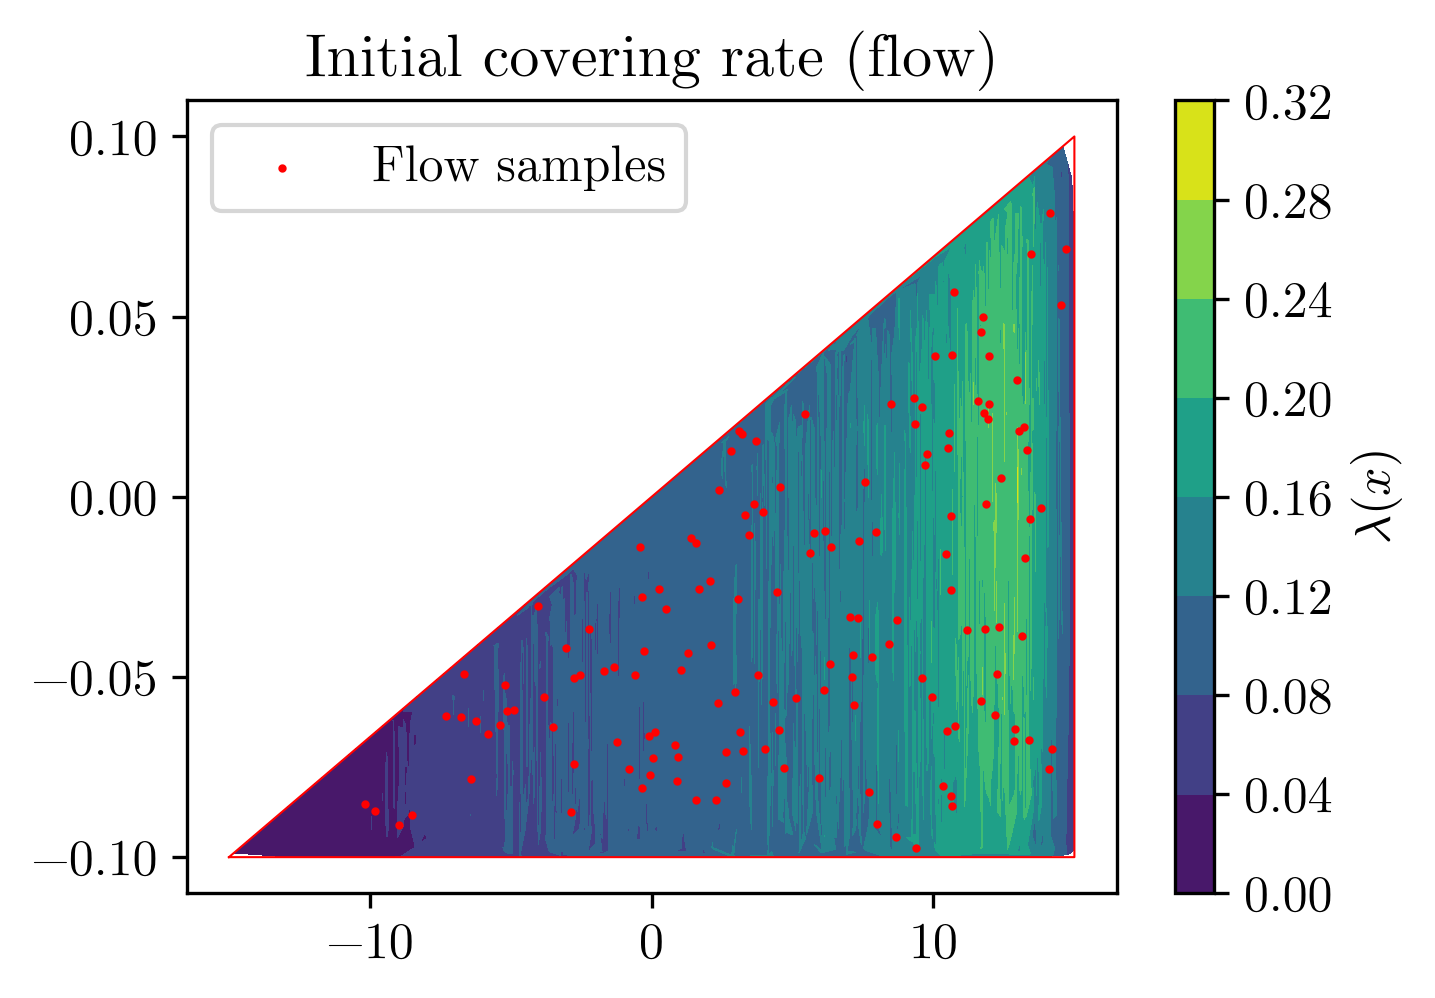

In [26]:
# Compute lam at some points
key, key_x, key_lam = random.split(key, 3)
xs = sample_uniform(key_x, 3000)
lam_ests = jax.lax.map(
    lambda val: get_lam_mc(val["key"], val["x"], 10, 1000, params),
    dict(key=random.split(key_lam, len(xs)), x=xs),
)

# Plot
plt.tricontourf(*xs.T, lam_ests)
plt.colorbar(label=r"$\lambda(x)$")
key, subkey = random.split(key)
xs = jax.lax.map(lambda key: sample_flow(key, params), random.split(subkey, 150))
plt.scatter(*xs.T, c="r", s=1, label="Flow samples")
plot_boundary()
# plt.gca().set_aspect("equal")
plt.legend()
plt.title("Initial covering rate (flow)")

$$p(x \, \mathrm{covered}) = \Lambda$$

In [27]:
n_ts = 10
n_fib = 1000
opt = optax.adam(2e-4)


@jax.jit
def loss(params, keys):
    def f(key):
        key_x, key_lam = random.split(key)
        x = sample_uniform(key_x, 1)[0]
        return get_lam_mc(key_lam, x, n_ts, n_fib, params)

    w1 = 0.1  # guess...
    lams = jax.lax.map(f, keys)
    return ((1 - w1) * jnp.log((1 - w1) / (1 - lams)) + w1 * jnp.log(w1 / lams)).sum()


@jax.jit
def update(params, opt_state, keys):
    """Learning rule"""
    value, grads = jax.value_and_grad(loss)(params, keys)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, value


# Training loop
opt_state = opt.init(params)
train_losses = []
n_steps = 400
batch_size = 512

with trange(n_steps) as pbar:
    for i in pbar:
        # Train
        key_tmp = random.split(key, batch_size + 1)
        key, keys = key_tmp[0], key_tmp[1:]
        params, opt_state, train_loss = update(params, opt_state, keys)
        train_losses.append(train_loss)
        pbar.set_description(f"loss: {train_losses[-1]}")

  0%|          | 0/400 [00:00<?, ?it/s]

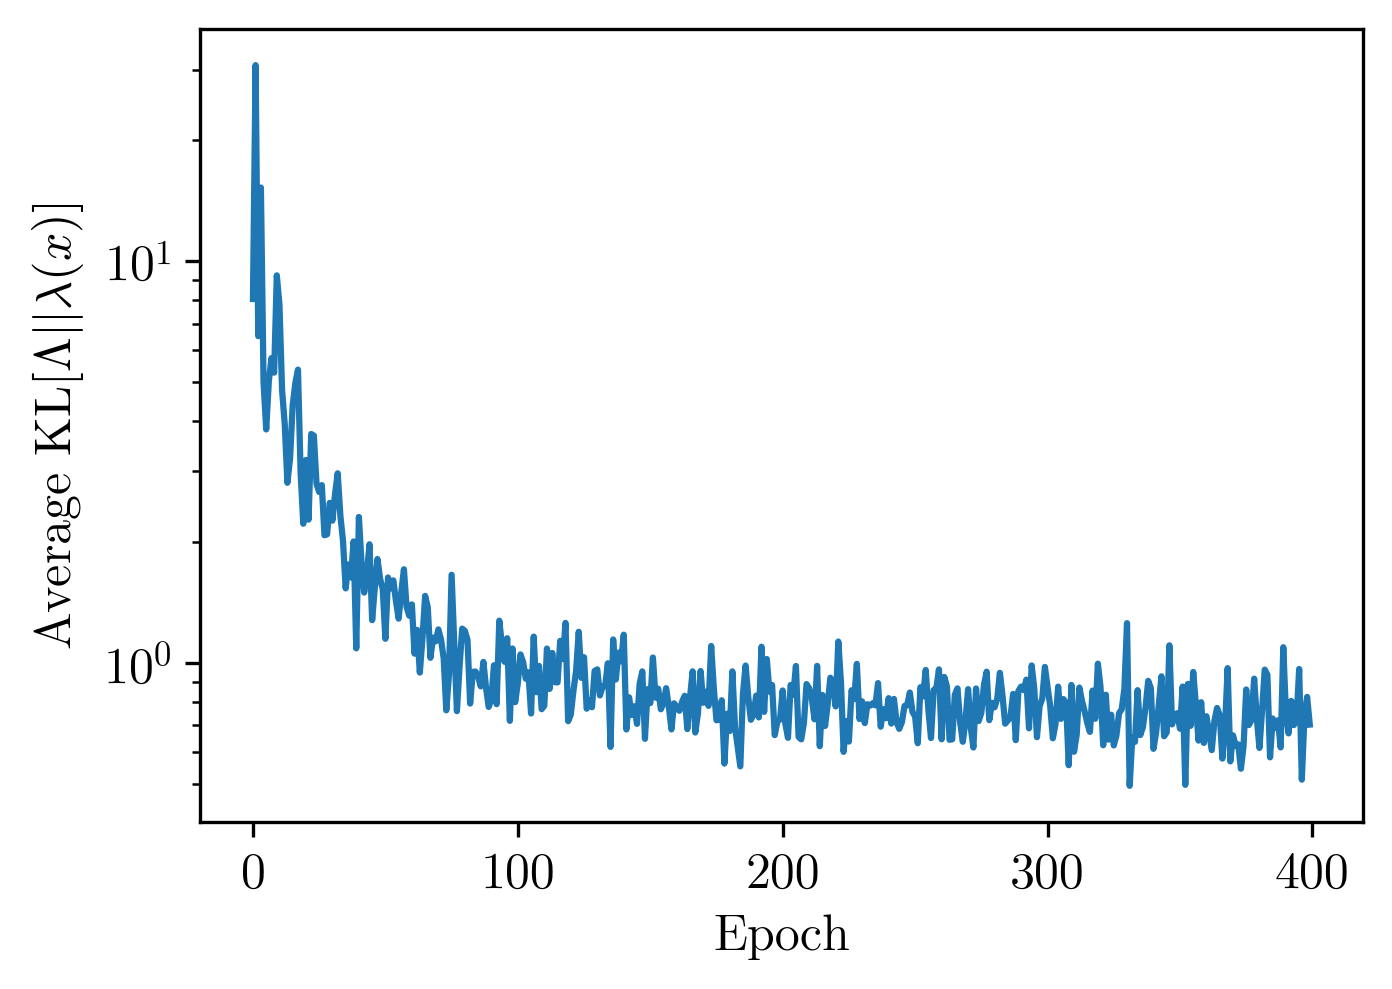

In [28]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel(r"Average $\operatorname{KL}[\Lambda || \lambda(x)]$")
plt.yscale("log")

Text(0.5, 1.0, 'Covering rate (flow)')

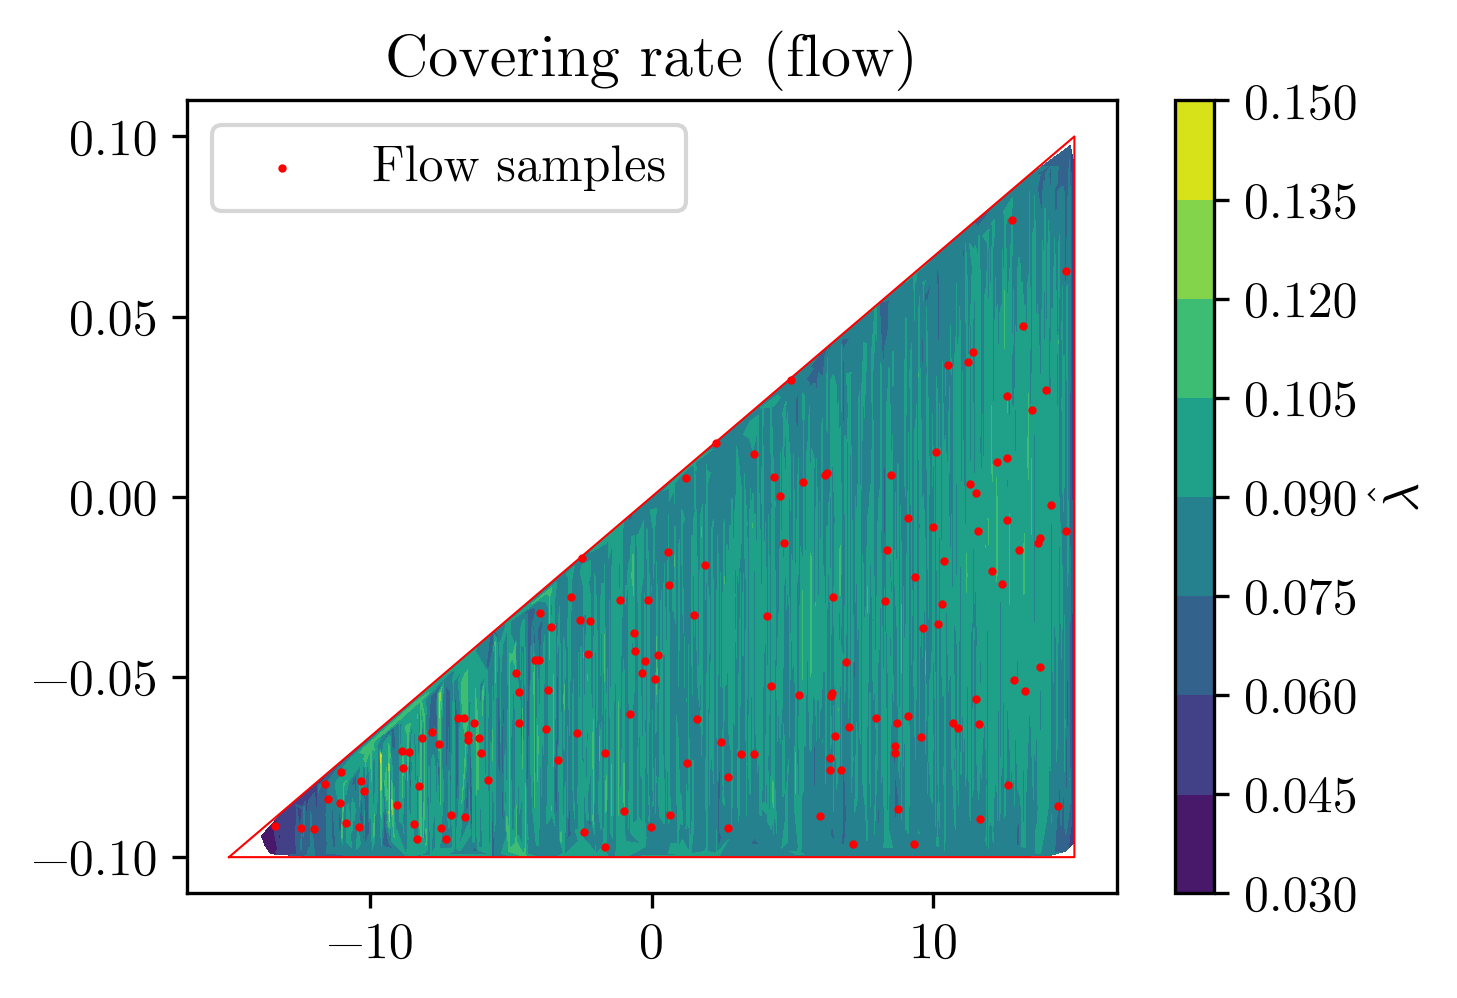

In [11]:
# Compute lam at some points
key, key_x, key_lam = random.split(key, 3)
xs = sample_uniform(key_x, 3000)
lam_ests = jax.lax.map(
    lambda val: get_lam_mc(val["key"], val["x"], 10, 1000, params),
    dict(key=random.split(key_lam, len(xs)), x=xs),
)

# Plot
plt.tricontourf(*xs.T, lam_ests)
plt.colorbar(label=r"$\hat{\lambda}$")
key, subkey = random.split(key)
xs = jax.lax.map(lambda key: sample_flow(key, params), random.split(subkey, 150))
plt.scatter(*xs.T, c="r", s=1, label="Flow samples")
plot_boundary()
# plt.gca().set_aspect("equal")
plt.legend()
plt.title("Covering rate (flow)")

Text(0.5, 1.0, 'Template density')

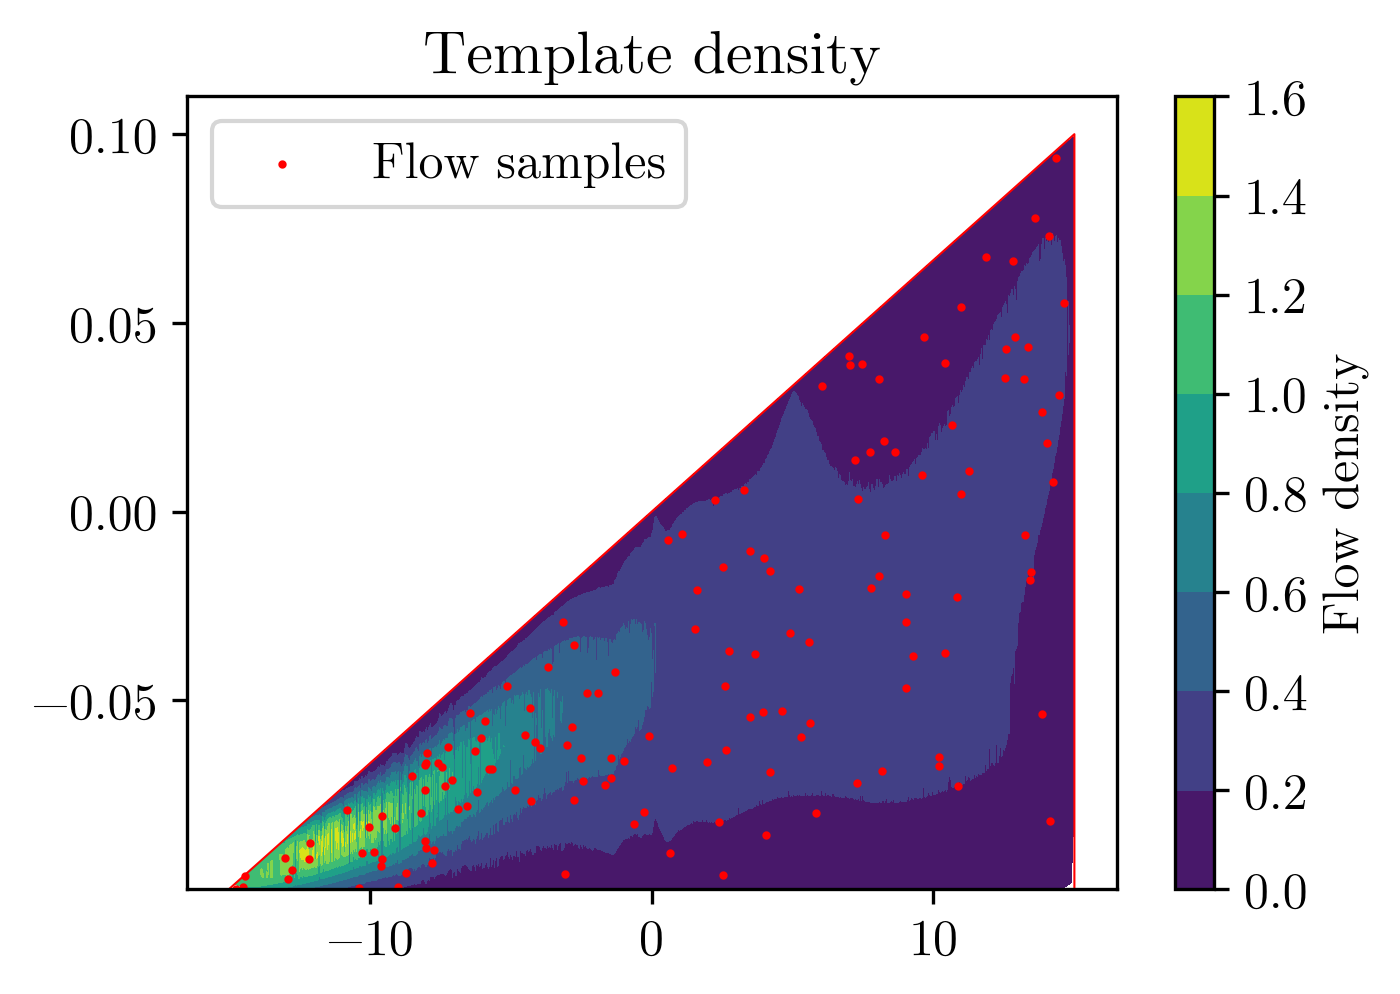

In [29]:
key, subkey = random.split(key)
xs = sample_uniform(subkey, 10000)
probs = jnp.exp(jax.lax.map(lambda x: log_pdf(params, x.reshape([1, 2])), xs))
plt.tricontourf(*xs.T, probs.squeeze())
plt.colorbar(label="Flow density")

xs = jax.lax.map(lambda key: sample_flow(key, params), random.split(subkey, 150))
plt.scatter(*xs.T, c="r", s=1, label="Flow samples")
plot_boundary()
plt.legend()
plt.title("Template density")

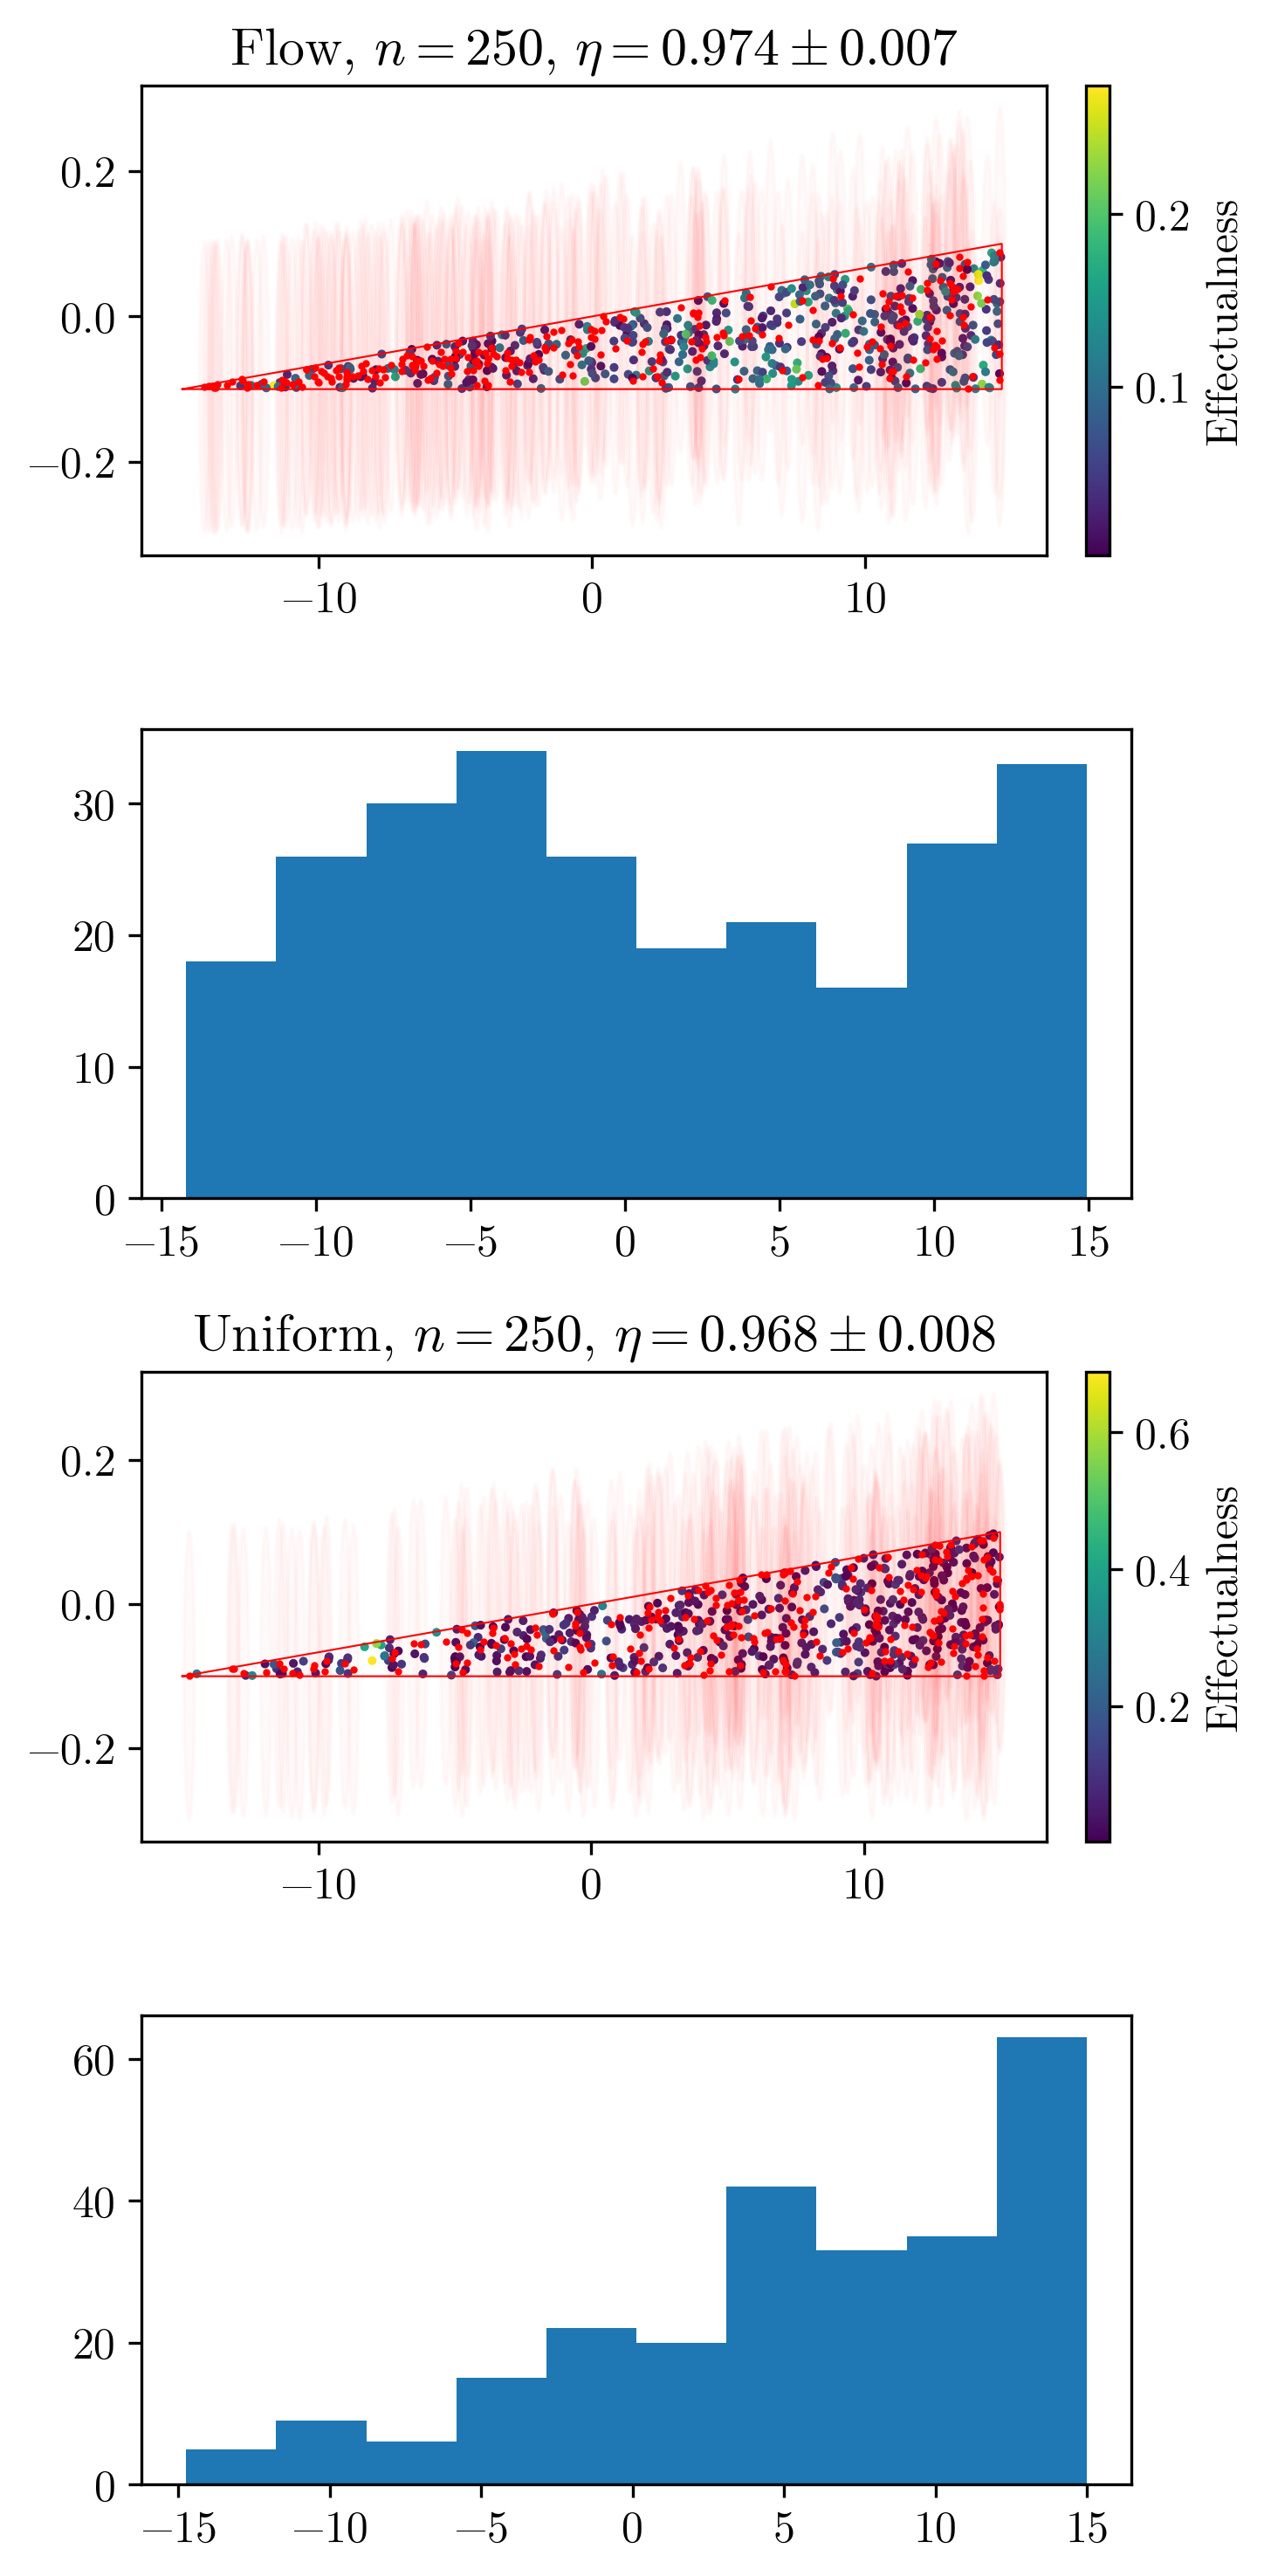

In [38]:
plt.figure(figsize=(5, 10))

n_bank = 250
n_eff = 500

plt.subplot(4, 1, 1)
# Generate bank and compute effectualness
key, subkey = random.split(key)
xs_bank, xs_eff, effs = get_effectualness(
    subkey, n_bank, n_eff, lambda key: sample_flow(key, params)
)
eta = (effs < radius).mean()
eta_err = (effs < radius).std() / jnp.sqrt(len(effs))
# Plot
plt.scatter(*xs_eff.T, s=2, c=effs)
plt.colorbar(label="Effectualness", fraction=0.046, pad=0.04)
plt.scatter(*xs_bank.T, s=1, c="r")
for x in xs_bank:
    plt.gca().add_patch(plt.Circle(x, radius, alpha=0.02, color="r"))
plot_boundary()
# plt.gca().set_aspect("equal")
plt.title(r"Flow, $n = %d$, $\eta = %.3f \pm %.3f$" % (n_bank, eta, eta_err))

plt.subplot(4, 1, 2)
plt.hist(xs_bank[:, 0])

plt.subplot(4, 1, 3)
# Generate bank and compute effectualness
key, subkey = random.split(key)
xs_bank, xs_eff, effs = get_effectualness(
    subkey, n_bank, n_eff, lambda key: sample_uniform(key, 1)[0]
)
eta = (effs < radius).mean()
eta_err = (effs < radius).std() / jnp.sqrt(len(effs))
# Plot
plt.scatter(*xs_eff.T, s=2, c=effs)
plt.colorbar(label="Effectualness", fraction=0.046, pad=0.04)
plt.scatter(*xs_bank.T, s=1, c="r")
for x in xs_bank:
    plt.gca().add_patch(plt.Circle(x, radius, alpha=0.02, color="r"))
plot_boundary()
# plt.gca().set_aspect("equal")
plt.title(r"Uniform, $n = %d$, $\eta = %.3f \pm %.3f$" % (n_bank, eta, eta_err))

plt.subplot(4, 1, 4)
plt.hist(xs_bank[:, 0])

plt.tight_layout()